**Student Name:** Raymond Willey<br>
**Student Pace:** Self-Paced<br>
**Scheduled Project Review Date/Time:**<br> 
**Instructor Name:** Eli Thomas<br>
**Blog post URL:**

<a id='overview'></a>
# Top Causes of Death in the United States: Overview
Worldwide health organizations want to plan budgets and strategize according to national and localized trends. In this case, we are working with data from 1999-2016 which highlights the leading causes of death in the United States at the state level. Our fictional organization would like to know which states will be at the highest level of risk in 2019 so that they can appropriately allocate resources. 

## Contents
1. [What is the leading cause of death in the United States?](#q1)
    - [Population Demographics](#demographics)
    - [Results](#q1results)
2. [Analyzing the National Trend for Leading Cause of Death](#q2)
3. [Identification of Contributing Factors in Addition to Demographic Data](#q3)<br>
    - [Factors Considered](#factors)
        * [Population Density](#density)
        * [Alcohol Consumption](#alcohol)
        * [Smoking Rates](#smoke)
        * [Diabetes](#diabetes)
        * [Target Variable: Deaths per Capita](#target)
    - [Data Exploration, Cleaning, & Feature Scaling](#transform)
    - [Regression Analysis](#linreg)
        * [Observations](#linreg_obs)
4. [Classification of High, Medium, and Low Risk States](#classify)
    - [Creating Feature Lags](#featlag)
5. [Machine Learning Models](#mlm)
    - [Feature Exploration & Heat Map](#featheat)
    - [Model Methodology](#methodology)
        * [Principal Component Analysis](#pca)
        * [Decision Tree](#tree)
        * [Logistic Regression](#logreg)
        * [Support Vector Machine](#svm)
        * [Random Forest](#rf)
        * [Adaboost](#ada)
        * [XGBoost](#xgb)
    - [Model Results](#modresults)
        * [Observations & Model Selection](#modobvs)
6. [2019 Predictions](#2019preds)
    - [Results](#2019results)
7. [Conclusions](#concs)
    - [Observations](#concobvs)
    - [Recommendation](#reco)
    - [Next Steps](#next)

<a id='q1'></a>
## What is the leading cause of death in the United States?
The [National Center for Health Statistics (NCHS)](#https://data.cdc.gov/NCHS/NCHS-Leading-Causes-of-Death-United-States/bi63-dtpu) provides data on the leading causes of death in the United States on an annual basis for each state. The data has been retrieved and saved to a dataframe below.

In [117]:
import time
T0 = time.time()

import warnings
warnings.simplefilter('ignore')

import pandas as pd
raw_df = pd.read_csv('causes_of_death.csv')
raw_df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2755,55.5
1,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,439,63.1
2,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4010,54.2
3,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1604,51.8
4,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,California,13213,32.0


#### Initial Cleaning: Columns to Drop
* **113 Cause Name:** Long name for *Cause Name*, and not required.
* **Age-adjusted Death Rate:** Interested in number of deaths per capita. Ambiguity in how this number is calculated.
* **Aggregated Data:** Drop rows where the cause name is *All causes* and state is *United States*.

In [118]:
df = raw_df[(raw_df['Cause Name'] != 'All causes') & (raw_df['State'] != 'United States')]
df = df.drop(columns = ['113 Cause Name', 'Age-adjusted Death Rate'])
df = df.rename(columns={'Cause Name': 'Cause_Name'})
df.head()

,Year,Cause_Name,State,Deaths
0,2016,Unintentional injuries,Alabama,2755
1,2016,Unintentional injuries,Alaska,439
2,2016,Unintentional injuries,Arizona,4010
3,2016,Unintentional injuries,Arkansas,1604
4,2016,Unintentional injuries,California,13213


<a id='demographics'></a>
### State Size (Population) - Centers for Disease Control & Prevention
In order to properly assess number of deaths per capita, population data must also be incorporated. This data was also obtained from the [NCHS](#https://wonder.cdc.gov/Bridged-Race-v2017.HTML) and saved locally to a .CSV file.

In [119]:
population = pd.read_csv('Bridged-Race Population Estimates 1999-2017.csv', nrows=36822)
population.head()

,Notes,Yearly July 1st Estimates,Yearly July 1st Estimates Code,State,State Code,Age Group,Age Group Code,Gender,Gender Code,Population
0,NaN,1999,1999,Alabama,1,< 1 year,1,Female,F,28712
1,NaN,1999,1999,Alabama,1,< 1 year,1,Male,M,30075
2,NaN,1999,1999,Alabama,1,1-4 years,4-Jan,Female,F,115715
3,NaN,1999,1999,Alabama,1,1-4 years,4-Jan,Male,M,120438
4,NaN,1999,1999,Alabama,1,5-9 years,9-May,Female,F,153779


#### Preprocessing 
Initial cleanup before joining with with main dataset.

##### Column Drops
* **Notes:** Mostly null values, no real value add.
* **Codes:** Prefer actual values (i.e. drop *Age Group Code* in favor of *Age Group*.<br>

##### Other Cleaning
* **Gender:** Set to boolean value to evaluate as **True** if *Male* or **False** if *Female*.

In [120]:
population = population.drop(columns=['Notes', 'Yearly July 1st Estimates Code', 'State Code', 'Age Group Code', 'Gender'])
population = population.rename(columns = {'Yearly July 1st Estimates': 'Year', 'Gender Code': 'Male'})
population['Male'] = population['Male'].replace(to_replace = {'F':0, 'M':1}).astype(bool)
population['Year'] = population['Year'].astype(int)
population.head()

,Year,State,Age Group,Male,Population
0,1999,Alabama,< 1 year,False,28712
1,1999,Alabama,< 1 year,True,30075
2,1999,Alabama,1-4 years,False,115715
3,1999,Alabama,1-4 years,True,120438
4,1999,Alabama,5-9 years,False,153779


#### Data Join
Demographic data will be relevant later, so in addition to population by state, gender and age percentages should also be joined with primary dataset.
1. Aggregate *Total Population* by State & Year
2. Aggregate *Male Population* by State & Year
3. Aggregate *Age Groups* by State & Year

In [121]:
# Create dataframe that aggregates total population by state and year
tot_pop = population.groupby(['State', 'Year']).sum().reset_index()
tot_pop['Year'] = tot_pop['Year'].astype(int)
tot_pop = tot_pop[['State', 'Year', 'Population']]
tot_pop.head()

,State,Year,Population
0,Alabama,1999,4430141
1,Alabama,2000,4452173
2,Alabama,2001,4467634
3,Alabama,2002,4480089
4,Alabama,2003,4503491


In [122]:
# Create dataframe that aggregates total male population by state and year
mf_df = population[population['Male'] == True].groupby(['State', 'Year']).sum().reset_index()
mf_df = mf_df.drop(columns=['Male'])
mf_df.head()

,State,Year,Population
0,Alabama,1999,2136882
1,Alabama,2000,2149338
2,Alabama,2001,2158138
3,Alabama,2002,2165719
4,Alabama,2003,2179422


In [123]:
# Create dataframe that aggregates total population by state, year, and age group
age_df = population.groupby(['Age Group', 'State', 'Year']).sum().reset_index()
age_df = age_df.drop(columns=['Male'])
print(age_df.shape)
age_df.head()

(18411, 4)


,Age Group,State,Year,Population
0,1-4 years,Alabama,1999,236153
1,1-4 years,Alabama,2000,235568
2,1-4 years,Alabama,2001,235087
3,1-4 years,Alabama,2002,237083
4,1-4 years,Alabama,2003,237183


##### Join Population & Demographic Data with Primary Dataset
1. Total Populaton & Gender Data (Represent *Gender* as percentage of the population)

In [124]:
pop_list = []
male_pop = []

# For each item in primary dataframe, look up total & male population values by year and state, then append to lists
for yr, st in zip(df['Year'], df['State']):
    
    pop = tot_pop['Population'].loc[(tot_pop['State'] == st) & (tot_pop['Year'] == yr)].values[0]
    pop_list.append(pop.astype(int))
    
    male = mf_df['Population'][(mf_df['State'] == st) & (mf_df['Year'] == yr)].values[0]
    male_pop.append(male)

# Create new columns from lists for total and male populations
df['Population'] = pop_list
df['Male_Population'] = male_pop

# Calculate male population as percentage of actual population
df['Percent_Male'] = df['Male_Population'] / df['Population']
df = df.drop(columns=['Male_Population'])
df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male
0,2016,Unintentional injuries,Alabama,2755,4860545,0.484347
1,2016,Unintentional injuries,Alaska,439,741522,0.523475
2,2016,Unintentional injuries,Arizona,4010,6908642,0.497096
3,2016,Unintentional injuries,Arkansas,1604,2988231,0.491298
4,2016,Unintentional injuries,California,13213,39296476,0.496812


#### Age Data

In [125]:
# For each item in primary dataframe, look up population by age group and add column as a percentage of total population
import numpy as np

# Create list of unique age groups and use as keys in dictionary for appending population data
age_groups = list(age_df['Age Group'].unique())
age_groups_dict = {}
for group in age_groups:
    age_groups_dict[group] =[]
age_groups_dict

# Lookup population for each age group by Year & State in primary dataframe
for group in age_groups:
    for yr, st in zip(df['Year'], df['State']):
    
        pop = age_df['Population'].loc[(age_df['State'] == st) & (age_df['Year'] == yr) & (age_df['Age Group'] == group)].values[0]
        age_groups_dict[group].append(pop)
        
    df[group] = np.array(age_groups_dict[group]) / df['Population']

df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male,1-4 years,10-14 years,15-19 years,20-24 years,...,5-9 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85+ years,< 1 year
0,2016,Unintentional injuries,Alabama,2755,4860545,0.484347,0.048362,0.063089,0.066052,0.069107,...,0.062506,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883,0.012039
1,2016,Unintentional injuries,Alaska,439,741522,0.523475,0.058669,0.066666,0.063703,0.077070,...,0.070705,0.066038,0.068670,0.060097,0.044579,0.027017,0.015993,0.009482,0.008518,0.015050
2,2016,Unintentional injuries,Arizona,4010,6908642,0.497096,0.050750,0.066415,0.067407,0.070282,...,0.065835,0.061377,0.062278,0.057501,0.055497,0.042170,0.030191,0.019872,0.019288,0.012329
3,2016,Unintentional injuries,Arkansas,1604,2988231,0.491298,0.051212,0.065944,0.066493,0.068473,...,0.065790,0.065482,0.066091,0.060369,0.054650,0.040212,0.029202,0.019792,0.019157,0.012787
4,2016,Unintentional injuries,California,13213,39296476,0.496812,0.050776,0.064177,0.065760,0.071632,...,0.064575,0.065988,0.064115,0.055368,0.046224,0.032182,0.022775,0.016168,0.018349,0.012455


In [126]:
# Rename age group columns so they are properly formatted for regression algorithm later
age_groups_renamed=[]
for group in age_groups:
    words = group.strip().split(' ')
    words[0] = words[0].replace('-', '_')
    words[0] = words[0].replace('+', '')
    age_groups_renamed.append(words[1]+'_'+words[0])
age_groups_renamed[-1] = 'years_1'
df = df.rename(columns=dict(zip(age_groups, age_groups_renamed)))
df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,...,years_5_9,years_50_54,years_55_59,years_60_64,years_65_69,years_70_74,years_75_79,years_80_84,years_85,years_1
0,2016,Unintentional injuries,Alabama,2755,4860545,0.484347,0.048362,0.063089,0.066052,0.069107,...,0.062506,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883,0.012039
1,2016,Unintentional injuries,Alaska,439,741522,0.523475,0.058669,0.066666,0.063703,0.077070,...,0.070705,0.066038,0.068670,0.060097,0.044579,0.027017,0.015993,0.009482,0.008518,0.015050
2,2016,Unintentional injuries,Arizona,4010,6908642,0.497096,0.050750,0.066415,0.067407,0.070282,...,0.065835,0.061377,0.062278,0.057501,0.055497,0.042170,0.030191,0.019872,0.019288,0.012329
3,2016,Unintentional injuries,Arkansas,1604,2988231,0.491298,0.051212,0.065944,0.066493,0.068473,...,0.065790,0.065482,0.066091,0.060369,0.054650,0.040212,0.029202,0.019792,0.019157,0.012787
4,2016,Unintentional injuries,California,13213,39296476,0.496812,0.050776,0.064177,0.065760,0.071632,...,0.064575,0.065988,0.064115,0.055368,0.046224,0.032182,0.022775,0.016168,0.018349,0.012455


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9180 entries, 0 to 10295
Data columns (total 25 columns):
Year            9180 non-null int64
Cause_Name      9180 non-null object
State           9180 non-null object
Deaths          9180 non-null int64
Population      9180 non-null int64
Percent_Male    9180 non-null float64
years_1_4       9180 non-null float64
years_10_14     9180 non-null float64
years_15_19     9180 non-null float64
years_20_24     9180 non-null float64
years_25_29     9180 non-null float64
years_30_34     9180 non-null float64
years_35_39     9180 non-null float64
years_40_44     9180 non-null float64
years_45_49     9180 non-null float64
years_5_9       9180 non-null float64
years_50_54     9180 non-null float64
years_55_59     9180 non-null float64
years_60_64     9180 non-null float64
years_65_69     9180 non-null float64
years_70_74     9180 non-null float64
years_75_79     9180 non-null float64
years_80_84     9180 non-null float64
years_85        9180 non-n

In [128]:
df.describe()

,Year,Deaths,Population,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,...,years_5_9,years_50_54,years_55_59,years_60_64,years_65_69,years_70_74,years_75_79,years_80_84,years_85,years_1
count,9180.00000,9180.000000,9.180000e+03,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,...,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000
mean,2007.50000,3725.386928,5.922638e+06,0.492744,0.052031,0.068364,0.070826,0.071147,0.066853,0.066474,...,0.066006,0.069527,0.061433,0.050565,0.040257,0.031708,0.025216,0.018588,0.017429,0.013093
std,5.18841,7161.711981,6.630446e+06,0.008032,0.005692,0.006569,0.005591,0.006880,0.008311,0.006810,...,0.006493,0.005873,0.008606,0.009434,0.007808,0.004743,0.003801,0.003211,0.004130,0.001638
min,1999.00000,21.000000,4.917800e+05,0.470729,0.038622,0.038807,0.053589,0.054894,0.049994,0.053501,...,0.042565,0.046077,0.035254,0.027146,0.019557,0.015225,0.010444,0.005645,0.003939,0.009192
25%,2003.00000,526.000000,1.594673e+06,0.487133,0.048646,0.064769,0.066981,0.067824,0.062653,0.062366,...,0.062667,0.065940,0.054970,0.042620,0.034698,0.029207,0.023603,0.016914,0.014704,0.012156
50%,2007.50000,1401.500000,4.131636e+06,0.491545,0.051847,0.068489,0.070818,0.070614,0.065976,0.065398,...,0.066178,0.069626,0.062753,0.050072,0.038503,0.031518,0.025338,0.018758,0.017298,0.013024
75%,2012.00000,3228.250000,6.706435e+06,0.497155,0.055125,0.072435,0.073654,0.073300,0.070258,0.069807,...,0.069421,0.073108,0.067628,0.058326,0.045277,0.034179,0.027176,0.020458,0.020401,0.013941
max,2016.00000,71930.000000,3.929648e+07,0.523698,0.077162,0.090548,0.099466,0.104689,0.123434,0.113322,...,0.090231,0.086697,0.082902,0.076172,0.068138,0.048455,0.038807,0.026185,0.027776,0.020272


<a id='q1results'></a>
### Group Data by Top Causes of Death & Inspect Results

In [129]:
top_causes = df[['Deaths', 'Population']].groupby(df['Cause_Name']).sum()
top_causes['Deaths_per_Capita'] = top_causes['Deaths'] / top_causes['Population']
top_causes

,Deaths,Population,Deaths_per_Capita
Cause_Name,,,
Alzheimer's disease,1373412,5436981948,0.000253
CLRD,2434726,5436981948,0.000448
Cancer,10244536,5436981948,0.001884
Diabetes,1316379,5436981948,0.000242
Heart disease,11575183,5436981948,0.002129
Influenza and pneumonia,1038969,5436981948,0.000191
Kidney disease,807980,5436981948,0.000149
Stroke,2580140,5436981948,0.000475
Suicide,649843,5436981948,0.000120


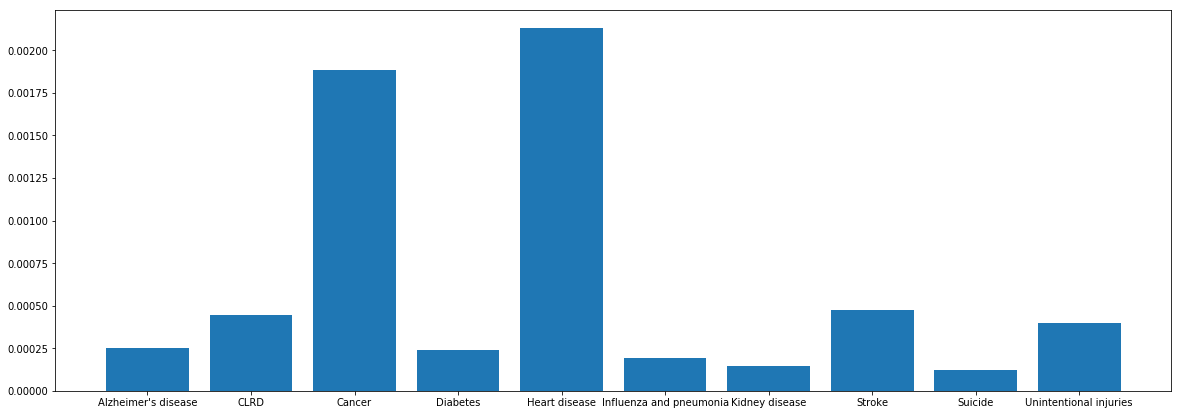

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))
plt.bar(top_causes.index, top_causes['Deaths_per_Capita'])
plt.show()

Leading causes of **Deaths_per_Capita** are **Heart Disease** and **Cancer**, and with heart disease slightly ahead. To determine if the difference in death rates between these causes is significant, a 2 tail F-Test for difference in population means will need to be performed.

### Hypothesis Testing
The following functions create visualizations and return the results for a 2-tail F-Test comparing population means.

In [131]:
def dist_plot(control, test, ctrl_label='Control Group', test_label='Test Group'):
    # Create a distribution plot to compare control and test groups for hypothesis testing
    plt.figure(figsize=(8, 8))
    sns.distplot(control, color='red', label=ctrl_label)
    sns.distplot(test, color='blue', label=test_label)
    plt.legend()
    plt.show()

In [132]:
from __future__ import print_function, division
import scipy.stats

def evaluate_PDF(rv, x=4):
    '''Input: a random variable object, standard deviation
       output : x and y values for the normal distribution
       '''
    
    # Identify the mean and standard deviation of random variable 
    mean = rv.mean()
    std = rv.std()

    # Use numpy to calculate evenly spaced numbers over the specified 
    # interval (4 sd) and generate 100 samples.
    xs = np.linspace(mean - x*std, mean + x*std, 100)
    
    # Calculate the peak of normal distribution i.e. probability density. 
    ys = rv.pdf(xs)

    return xs, ys # Return calculated values

In [133]:
def norm_dist(control, test, ctrl_label='Control Group', test_label='Test Group'):
    # Evaluate the PDF's of control and test groups and generate 
    # normal distributions to visualize the mean and variance differences
    control_mean, control_std = np.mean(control), np.std(control)
    control_quant = scipy.stats.norm(control_mean, control_std)

    test_mean, test_std = np.mean(test), np.std(test)
    test_quant = scipy.stats.norm(test_mean, test_std)
    
    plt.figure(figsize=(8, 8))

    xs, ys = evaluate_PDF(control_quant)
    plt.plot(xs, ys, label=ctrl_label, linewidth=4, color='red')
    plt.axvline(x=control_mean, color='red', ls='-.', label=f'{ctrl_label} Mean: {np.round(control_mean, 4)}')

    xs, ys = evaluate_PDF(test_quant)
    plt.plot(xs, ys, label=test_label, linewidth=4, color='blue') 
    plt.axvline(x=test_mean, color='blue', ls='-.', label=f'{test_label} Mean: {np.round(test_mean, 4)}')

    plt.xlabel('Death Rate')
    plt.legend()
    plt.show()


In [134]:
from scipy import stats

def test_results(control, test):
    return stats.ttest_ind(test, control)

In [135]:
def get_results(control, test, ctrl_label='Control Label', test_label='Test Label', conf_lvl = .95):
    # Determine if the mean differences between control and test groups are statistically significant
    # If so, display results & distribution plots, evaluate the PDF's, and provide normal distribution visualizations
    
    ctrl_mean, ctrl_std = np.mean(control), np.std(control)
    test_mean, test_std = np.mean(test), np.std(test)
    
    mean_diff = (test_mean - ctrl_mean) / ctrl_mean
    std_diff = (test_std - ctrl_std) / ctrl_std
    
    t_stat, p_val = test_results(control, test)
    
#   Print all key metrics for the test group if results are statistically significant, along with relevant plots.
#   Otherwise, indicate that the results are not significant at the given confidence level.
    print(f'Key Metrics for {test_label}')    
    if p_val < (1-conf_lvl):
        print(f'  {ctrl_label} Mean: {np.round(ctrl_mean, 6)}')
        print(f'  {test_label} Mean: {np.round(test_mean, 6)}')
        print(f'  Percent Mean Difference: {np.round(100 * mean_diff, 2)}%\n')
        print(f'  {ctrl_label} Std Dev: {np.round(ctrl_std, 6)}')
        print(f'  {test_label} Std Dev: {np.round(test_std, 6)}')
        print(f'  Percent Std Dev Difference: {np.round(100 * std_diff, 2)}%')
        print(f'  Test Statistic: {np.round(t_stat, 4)}')
        print(f'  P-Value: {p_val}')
        dist_plot(control, test, ctrl_label=ctrl_label, test_label=test_label)
        norm_dist(control, test, ctrl_label=ctrl_label, test_label=test_label)
    else:
        print(f'{test_label} Not Significant at {np.round(100*conf_lvl, 2)}% Confidence Level\n')
        
#   Regardless of significance, return the key statistics to a dictionary for evaluation.
    keys = ['Ctrl Mean', 'Ctrl Std', 'Test Mean', 'Test Std', 'Mean Diff', 'Std Diff', 't-stat', 'p_val']   
    values = [ctrl_mean, ctrl_std, test_mean, test_std, mean_diff, std_diff, t_stat, p_val]
    return dict(zip(keys, values))

In [136]:
causes = df['Cause_Name'].value_counts().index

### Create Dataframes to Compare Cancer to Heart Disease

In [137]:
cancer = df[df['Cause_Name'] == 'Cancer'][['Deaths', 'Population']].groupby(df['Year']).sum()
cancer['Deaths_per_Capita'] = cancer['Deaths'] / cancer['Population']
cancer = cancer.drop(columns = ['Deaths', 'Population'])

hd = df[df['Cause_Name'] == 'Heart disease'][['Deaths', 'Population']].groupby(df['Year']).sum()
hd['Deaths_per_Capita'] = hd['Deaths'] / hd['Population']
hd = hd.drop(columns = ['Deaths', 'Population'])

hd

,Deaths_per_Capita
Year,
1999,0.002599
2000,0.002519
2001,0.002457
2002,0.002423
2003,0.002361
2004,0.002228
2005,0.002207
2006,0.002117
2007,0.002045


In [138]:
cancer

,Deaths_per_Capita
Year,
1999,0.001970
2000,0.001960
2001,0.001943
2002,0.001937
2003,0.001920
2004,0.001892
2005,0.001893
2006,0.001876
2007,0.001869


Key Metrics for Heart Disease
  Cancer Mean: 0.001886
  Heart Disease Mean: 0.002139
  Percent Mean Difference: 13.4%

  Cancer Std Dev: 4.1e-05
  Heart Disease Std Dev: 0.000229
  Percent Std Dev Difference: 466.01%
  Test Statistic: 4.4751
  P-Value: 8.141904785739937e-05


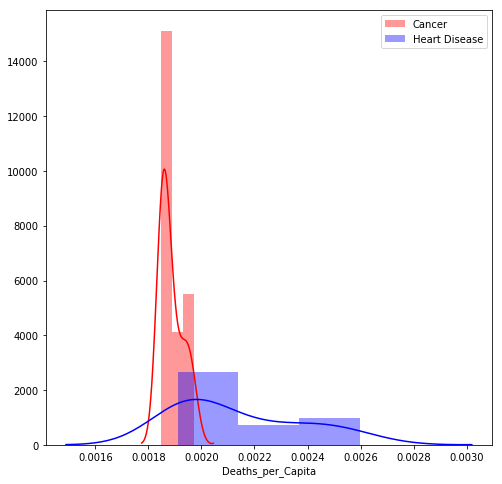

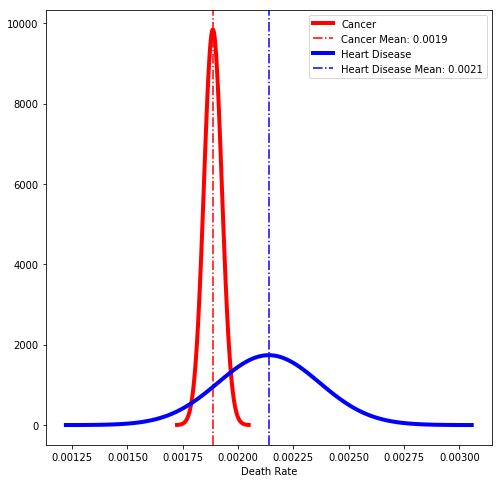

In [139]:
import seaborn as sns

cancer_hd_results = get_results(cancer['Deaths_per_Capita'], hd['Deaths_per_Capita'], ctrl_label = 'Cancer', test_label='Heart Disease')

P-Value less than 0.000% indicates that there a statistically significant difference in means between heart disease and cancer. The difference in means is 13.4%. Furthermore, a difference in variance of 466% indicates cancer rates are much more consistent than those of heart disease. This suggests that rates in heart disease are more likely to influenced by external factors as opposed to specific demographics.

<a id='q2'></a>
### Compare Heart Disease Rates in 1999 & 2016 to Determine if Death Rates have Changed Significantly

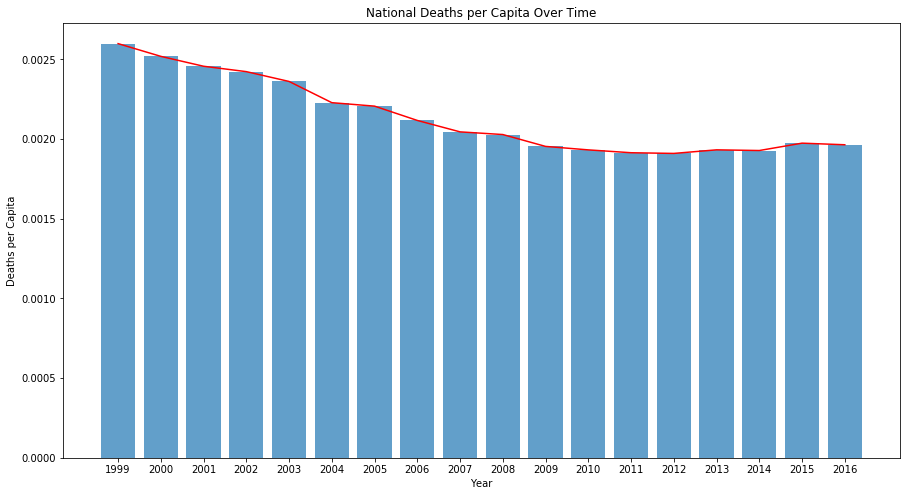

In [140]:
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

xs = hd.index
ys = hd['Deaths_per_Capita']

ax.bar(xs, ys, alpha=.7)
ax.plot(xs, ys, color='r')

plt.xticks(list(range(1999, 2017, 1)))
plt.xlabel('Year')
plt.ylabel('Deaths per Capita')
plt.title('National Deaths per Capita Over Time')

plt.show()

Key Metrics for Heart Disease 2016
  Heart Disease 1999 Mean: 0.002537
  Heart Disease 2016 Mean: 0.002005
  Percent Mean Difference: -20.98%

  Heart Disease 1999 Std Dev: 0.000547
  Heart Disease 2016 Std Dev: 0.000373
  Percent Std Dev Difference: -31.79%
  Test Statistic: -5.682
  P-Value: 1.3157447549025112e-07


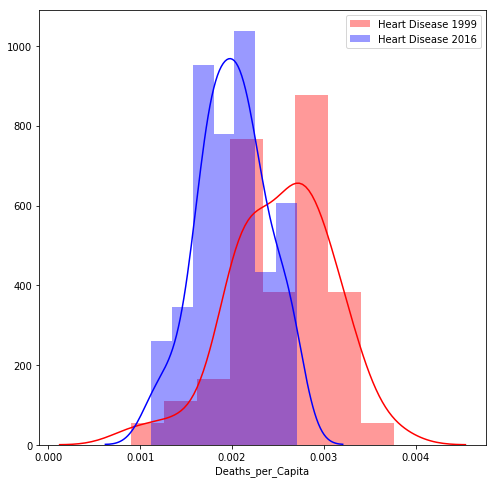

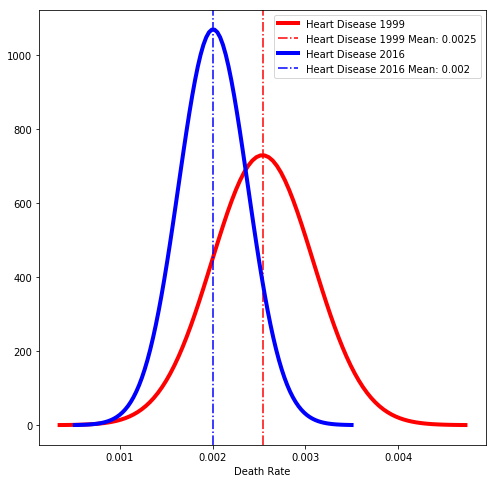

In [141]:
hd_yoy = df[df['Cause_Name'] == 'Heart disease'][['Year', 'State', 'Deaths', 'Population']]
hd_yoy['Deaths_per_Capita'] = hd_yoy['Deaths'] / hd_yoy['Population']

hd1999 = hd_yoy[hd_yoy['Year'] == 1999]['Deaths_per_Capita']
hd2016 = hd_yoy[hd_yoy['Year'] == 2016]['Deaths_per_Capita']

# hd1999 = df[(df['Cause_Name'] == 'Heart disease') & (df['Year']==1999)]['Deaths']
# hd2016 = df[(df['Cause_Name'] == 'Heart disease') & (df['Year']==2016)]['Deaths']
hd_results = get_results(hd1999, hd2016, ctrl_label = 'Heart Disease 1999', test_label='Heart Disease 2016', conf_lvl=.95)

Given a P-Value less than 0.000, with a difference in means of 20.98%, we can safely conclude that the rate of heart disease deaths has significantly decreased since 1999. While this does not alone take into account variances with regard to state size, it is consistent with the national trend, suggesting state by state variance is not a significant factor.

<a id='q3'></a>
## Which factors have the greatest impact on heart disease deaths?
### Factors Considered
* Population Density
* Age Demographic (already incorporated into dataset)
* Gender Demographic (already incorporated into dataset)
* Alcohol Consumption
* Smoking Population
* Diabetes Rates

First step is to create a dataframe that focused explicitly on Heart Disease

In [142]:
hd_df = df[df['Cause_Name'] == 'Heart disease']
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,...,years_5_9,years_50_54,years_55_59,years_60_64,years_65_69,years_70_74,years_75_79,years_80_84,years_85,years_1
4731,2016,Heart disease,Alabama,12832,4860545,0.484347,0.048362,0.063089,0.066052,0.069107,...,0.062506,0.068272,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883,0.012039
4732,2015,Heart disease,Alabama,12981,4850858,0.484665,0.048409,0.063828,0.065925,0.071293,...,0.062936,0.070043,0.069515,0.061801,0.053638,0.038927,0.027938,0.018973,0.017619,0.012179
4733,2014,Heart disease,Alabama,12461,4840037,0.484787,0.048594,0.064846,0.065804,0.073148,...,0.063281,0.071178,0.069157,0.060680,0.051657,0.038005,0.027491,0.018777,0.017302,0.012057
4734,2013,Heart disease,Alabama,12472,4827660,0.484981,0.049125,0.065616,0.066477,0.073858,...,0.063570,0.071612,0.068900,0.059918,0.049688,0.036849,0.026860,0.018685,0.016942,0.011886
4735,2012,Heart disease,Alabama,12036,4813946,0.485060,0.049996,0.066419,0.067235,0.073380,...,0.063502,0.072093,0.068041,0.059722,0.048072,0.035264,0.026260,0.018758,0.016657,0.012156


<a id='density'></a>
#### 1. Population Density
Data related to state, geographical area initially scraped from [State Symbols USA](#www.statesymbolsusa.org), then saved to .CSV to prevent need for future scraping

In [27]:
# from bs4 import BeautifulSoup
# import requests

# state_sizes = []

# url = 'https://statesymbolsusa.org/symbol-official-item/national-us/uncategorized/states-size'
# html_page = requests.get(url) #Make a get request to retrieve the page
# soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing

# state_sizes = soup.find_all('td')

In [28]:
# state_sizes[:10]

In [29]:
# # Save relevant data to dictionary and create dataframe
# state_data = state_sizes[3:]
# states_dict = {'State':[], 'Square Miles (Land Area)':[]}

# for i in range(int(len(state_data)/3)):
#     states_dict['State'].append(state_data[i*3 + 1].text)
#     states_dict['Square Miles (Land Area)'].append(float(state_data[i*3 + 2].text.replace(',', '')))

# # Manually enter data for District of Columbia from Google Maps
# states_dict['State'].append('District of Columbia')
# states_dict['Square Miles (Land Area)'].append(68.34)
# state_sizes = pd.DataFrame.from_dict(states_dict)
# state_sizes.head()

In [30]:
# # Save dataframe to csv
# state_sizes.to_csv('state_sizes.csv')

In [143]:
state_sizes = pd.read_csv('state_sizes.csv')
state_sizes = state_sizes[state_sizes.columns[1:]]
state_sizes.head()

,State,Square Miles (Land Area)
0,Alaska,570641.0
1,Texas,261914.0
2,California,155973.0
3,Montana,145556.0
4,New Mexico,121365.0


In [144]:
# Add state size to primary dataframe to determine population density
sq_miles = [state_sizes['Square Miles (Land Area)'][state_sizes['State'] == st].values[0] for st in hd_df['State']]
hd_df['Sq_Miles'] = sq_miles
hd_df['Pop_Density'] = hd_df['Population'] / hd_df['Sq_Miles']
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,...,years_55_59,years_60_64,years_65_69,years_70_74,years_75_79,years_80_84,years_85,years_1,Sq_Miles,Pop_Density
4731,2016,Heart disease,Alabama,12832,4860545,0.484347,0.048362,0.063089,0.066052,0.069107,...,0.069594,0.062994,0.055756,0.039662,0.028487,0.019281,0.017883,0.012039,50750.0,95.774286
4732,2015,Heart disease,Alabama,12981,4850858,0.484665,0.048409,0.063828,0.065925,0.071293,...,0.069515,0.061801,0.053638,0.038927,0.027938,0.018973,0.017619,0.012179,50750.0,95.583409
4733,2014,Heart disease,Alabama,12461,4840037,0.484787,0.048594,0.064846,0.065804,0.073148,...,0.069157,0.060680,0.051657,0.038005,0.027491,0.018777,0.017302,0.012057,50750.0,95.370187
4734,2013,Heart disease,Alabama,12472,4827660,0.484981,0.049125,0.065616,0.066477,0.073858,...,0.068900,0.059918,0.049688,0.036849,0.026860,0.018685,0.016942,0.011886,50750.0,95.126305
4735,2012,Heart disease,Alabama,12036,4813946,0.485060,0.049996,0.066419,0.067235,0.073380,...,0.068041,0.059722,0.048072,0.035264,0.026260,0.018758,0.016657,0.012156,50750.0,94.856079


<a id='alcohol'></a>
#### 2. Alcohol Consumption
Data scraped from the [National Institute on Alcohol Abuse and Alcoholism](#https://pubs.niaaa.nih.gov/publications/surveillance110/tab4-1_16.htm). Data exists across 16 different pages for which each needed to be individually scraped. Data saved to CSV to prevent need for further scraping should site structure change.

Results indicate the total gallons of alcohol consumed per capita for wine, spirit, and beer consumption are based on sales data and percentage of the population that is 14 years and older. 

**Note: results do not show total gallons of alcohol type consumed, but amount of alcohol consumed from the given type. For example, 750ml of a liquor that is 50% alcohol results in 375ml of alcohol consumed.**

In [33]:
# years = []
# datagray = []
# data = []
# states = []

# for i in range(1, 17, 1):
#     print(f'Page {i} of 16 ({100 * i/16:.2f}% Complete)')
#     url = f'https://pubs.niaaa.nih.gov/publications/surveillance110/tab4-{i}_16.htm'
#     html_page = requests.get(url) #Make a get request to retrieve the page
#     soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing
    
#     states += soup.find_all('strong')
#     years += soup.find_all('th', class_='stubs')
    
#     # td represents table data, with class given by shading
#     # Beer & spirits exist are the first two gray shaded columns, while wine & all beverages are the first two unshaded columns
#     datagray += soup.find_all('td', class_='datagray')
#     data += soup.find_all('td', class_='data')
#     time.sleep(2)

In [34]:
# # Drop table names stored in with same tag as state name
# state_txt = []
# for state in states:
#     if state.text != 'Table 4.':
#         state_txt.append(state.text)       
# state_txt[:5]

In [35]:
# # Save content to dictionary for conversion to dataframe
# alcohol = {'state':[], 'year':[], 'beer':[], 'wine':[], 'spirits':[], 'all_bevs': []}

# for i in range(len(years)):
#     # New state every 40 years
#     # 3 datagray items for each year, 2 data items for each year
#     alcohol['year'].append(years[i].text) 
#     alcohol['state'].append(state_txt[int(i/40)])
#     alcohol['beer'].append(datagray[i*3].text)
#     alcohol['wine'].append(data[i*2].text)
#     alcohol['spirits'].append(datagray[i*3 + 1].text)
#     alcohol['all_bevs'].append(data[i*2 + 1].text)

In [36]:
# # Convert dictionary to dataframe and save as CSV to prevent need for future scraping
# alcohol_df = pd.DataFrame.from_dict(alcohol)

# alcohol_df['year'] = alcohol_df['year'].astype(int)
# for k in list(alcohol.keys())[2:]:
#     alcohol_df[k] = alcohol_df[k].astype(float)

# alcohol_df.to_csv('alcohol_df.csv')
# alcohol_df.head()

In [145]:
# Read data from CSV
alcohol_df = pd.read_csv('alcohol_df.csv', index_col=0)
alcohol_df.describe()

,year,beer,wine,spirits,all_bevs
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1996.500000,1.287589,0.341455,0.845817,2.475192
std,11.545974,0.226351,0.179546,0.349340,0.613162
min,1977.000000,0.630000,0.080000,0.360000,1.190000
25%,1986.750000,1.130000,0.210000,0.640000,2.120000
50%,1996.500000,1.280000,0.310000,0.765000,2.360000
75%,2006.250000,1.410000,0.450000,0.950000,2.700000
max,2016.000000,2.170000,1.190000,3.560000,6.320000


In [146]:
# Add alcohol data to primary dataframe
alcohol_dict = {'all_bevs':[], 'beer':[], 'wine':[], 'spirits':[]}

for yr, st in zip(hd_df['Year'], hd_df['State']):
    for key in alcohol_dict.keys():
        alcohol_dict[key].append(alcohol_df[key][(alcohol_df['state'] == st) & (alcohol_df['year'] == yr)].values[0])

for key in alcohol_dict.keys():
    hd_df[key] = alcohol_dict[key]
    
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,...,years_75_79,years_80_84,years_85,years_1,Sq_Miles,Pop_Density,all_bevs,beer,wine,spirits
4731,2016,Heart disease,Alabama,12832,4860545,0.484347,0.048362,0.063089,0.066052,0.069107,...,0.028487,0.019281,0.017883,0.012039,50750.0,95.774286,2.01,1.09,0.26,0.65
4732,2015,Heart disease,Alabama,12981,4850858,0.484665,0.048409,0.063828,0.065925,0.071293,...,0.027938,0.018973,0.017619,0.012179,50750.0,95.583409,2.01,1.11,0.26,0.64
4733,2014,Heart disease,Alabama,12461,4840037,0.484787,0.048594,0.064846,0.065804,0.073148,...,0.027491,0.018777,0.017302,0.012057,50750.0,95.370187,2.00,1.13,0.25,0.62
4734,2013,Heart disease,Alabama,12472,4827660,0.484981,0.049125,0.065616,0.066477,0.073858,...,0.026860,0.018685,0.016942,0.011886,50750.0,95.126305,1.99,1.14,0.25,0.60
4735,2012,Heart disease,Alabama,12036,4813946,0.485060,0.049996,0.066419,0.067235,0.073380,...,0.026260,0.018758,0.016657,0.012156,50750.0,94.856079,2.00,1.16,0.24,0.60


<a id='smoke'></a>
#### 3. Smoking
This multi-purpose dataset from the [United Health Foundation](#https://www.americashealthrankings.org/explore/annual/measure/Smoking/state/ALL) includes smoking rates for each state. Each year is saved as a separate csv.

*Results represent percentage of population that have smoked at least 100 cigarettes in their lifetime.*

In [147]:
# Create initial dataframe for 1999 data
smoking = pd.read_csv('smoking/1999-Annual.csv')

# Append data for each initial year
for i in range(2000, 2017):
    smoke_yr = pd.read_csv(f'smoking/{str(i)}-Annual.csv')
    smoking = smoking.append(smoke_yr)

# Show results relevant to smoking and drop rows where national data is aggregated
smoking = smoking[(smoking['Measure Name'] == 'Smoking') & (smoking['State Name'] != 'United States')] 
smoking['Year'] = smoking['Report Type'].astype(str).str[:4].astype(int)
smoking = smoking[['Year', 'State Name', 'Value']].reset_index(drop=True)
smoking['Value'] = smoking['Value'].astype(float)
smoking = smoking.rename(columns = {'State Name': 'State'})
smoking.head()

,Year,State,Value
0,1999,Alabama,24.6
1,1999,Alaska,26.1
2,1999,Arizona,21.8
3,1999,Arkansas,25.9
4,1999,California,19.2


In 2012, the methodology for determining smoking rates changed, resulting in a spike for 2012 data and beyond. Because we are more interested in the change in smoking rates from year to year rather than the exact rate itself, all values in 2012 and after must be scaled to align with prior year methodologies.

**Key Assumption: Geometric mean of year-over-year changes for 2006-2011 used to adjust 2012 rates and beyond.**

In [148]:
state_list = smoking['State'].unique()

state_adjs = {}
est_adjs = []

# Calculate 2012 percentage adjustment for each state and save to dictionary
for st in state_list:
    prev = smoking['Value'][(smoking['State'] == st) & (smoking['Year']==2006)].values[0]
    new = smoking['Value'][(smoking['State'] == st) & (smoking['Year']==2011)].values[0]
    cur = smoking['Value'][(smoking['State'] == st) & (smoking['Year']==2012)].values[0]
    new_val = new * (new / prev) ** .2
    adj = new_val / cur
    state_adjs[st] = adj

# 2012 adjustment calculation applied to each period thereafter, otherwise set to 1 (no adjustment)
for yr, st in zip(smoking['Year'], smoking['State']):
    est_adjs.append(1) if yr <= 2011 else est_adjs.append(state_adjs[st])

# Add adjustment calculations and adjusted values to smoking dataframe
smoking['Estimated Adjustment'] = est_adjs
smoking['Adjusted Value'] = smoking['Value'] * smoking['Estimated Adjustment']
smoking[smoking['State'] == 'New York']

,Year,State,Value,Estimated Adjustment,Adjusted Value
31,1999,New York,24.1,1.000000,24.100000
82,2000,New York,21.8,1.000000,21.800000
133,2001,New York,21.6,1.000000,21.600000
184,2002,New York,23.2,1.000000,23.200000
235,2003,New York,22.3,1.000000,22.300000
286,2004,New York,21.6,1.000000,21.600000
337,2005,New York,19.9,1.000000,19.900000
388,2006,New York,20.5,1.000000,20.500000
439,2007,New York,18.2,1.000000,18.200000
490,2008,New York,18.9,1.000000,18.900000


In [149]:
# Look up smoking rate for each given year and state in primary dataset.
smoking_list = []
smoking_list_raw = []

for yr, st in zip(hd_df['Year'], hd_df['State']):   
    smoke_rate = smoking['Adjusted Value'][(smoking['State'] == st) & (smoking['Year'] == yr)].values[0]
    smoke_rate_raw = smoking['Value'][(smoking['State'] == st) & (smoking['Year'] == yr)].values[0]
    smoking_list.append(smoke_rate)
    smoking_list_raw.append(smoke_rate_raw)
    
hd_df['Smoking'] = np.array(smoking_list)/100
hd_df['Smoking_unadj'] = np.array(smoking_list_raw)/100
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,...,years_85,years_1,Sq_Miles,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Smoking_unadj
4731,2016,Heart disease,Alabama,12832,4860545,0.484347,0.048362,0.063089,0.066052,0.069107,...,0.017883,0.012039,50750.0,95.774286,2.01,1.09,0.26,0.65,0.188127,0.214
4732,2015,Heart disease,Alabama,12981,4850858,0.484665,0.048409,0.063828,0.065925,0.071293,...,0.017619,0.012179,50750.0,95.583409,2.01,1.11,0.26,0.64,0.185489,0.211
4733,2014,Heart disease,Alabama,12461,4840037,0.484787,0.048594,0.064846,0.065804,0.073148,...,0.017302,0.012057,50750.0,95.370187,2.00,1.13,0.25,0.62,0.189006,0.215
4734,2013,Heart disease,Alabama,12472,4827660,0.484981,0.049125,0.065616,0.066477,0.073858,...,0.016942,0.011886,50750.0,95.126305,1.99,1.14,0.25,0.60,0.209225,0.238
4735,2012,Heart disease,Alabama,12036,4813946,0.485060,0.049996,0.066419,0.067235,0.073380,...,0.016657,0.012156,50750.0,94.856079,2.00,1.16,0.24,0.60,0.213620,0.243


#### Calculate adjustment on national level and save as CSV

In [150]:
# Extract relevent columns from hd_df
mean_smoking_df = hd_df[['Year', 'State', 'Population', 'Smoking', 'Smoking_unadj']]
hd_df = hd_df.drop(columns=['Smoking_unadj'])

# Calulate absolute counts of smoking populaton
mean_smoking_df['Pop_Smoke'] = mean_smoking_df['Smoking'] * mean_smoking_df['Population']
mean_smoking_df['Pop_Smoke_unadj'] = mean_smoking_df['Smoking_unadj'] * mean_smoking_df['Population']

#Group by year and sum numbers
mean_smoking_df = mean_smoking_df.groupby('Year').sum().drop(columns=['Smoking', 'Smoking_unadj'])
mean_smoking_df.tail(7)

,Population,Pop_Smoke,Pop_Smoke_unadj
Year,,,
2010,309338421,5.569850e+07,5.569850e+07
2011,311644280,5.323349e+07,5.323349e+07
2012,313993272,5.172395e+07,6.316453e+07
2013,316234505,4.886223e+07,5.964738e+07
2014,318622525,4.742833e+07,5.786216e+07
2015,321039839,4.568577e+07,5.572031e+07
2016,323405935,4.433741e+07,5.405886e+07


In [151]:
# Recalculate smoking rates based on population sums and 
mean_smoking_df['Smoking'] = mean_smoking_df['Pop_Smoke'] / mean_smoking_df['Population']
mean_smoking_df['Smoking_unadj'] = mean_smoking_df['Pop_Smoke_unadj'] / mean_smoking_df['Population']

# Absolute counts no longer required
mean_smoking_df = mean_smoking_df.drop(columns = ['Population', 'Pop_Smoke', 'Pop_Smoke_unadj'])
mean_smoking_df.tail(6)

,Smoking,Smoking_unadj
Year,,
2011,0.170815,0.170815
2012,0.164729,0.201165
2013,0.154513,0.188618
2014,0.148854,0.181601
2015,0.142306,0.173562
2016,0.137095,0.167155


In [152]:
mean_smoking_df.to_csv('mean_smoking.csv')

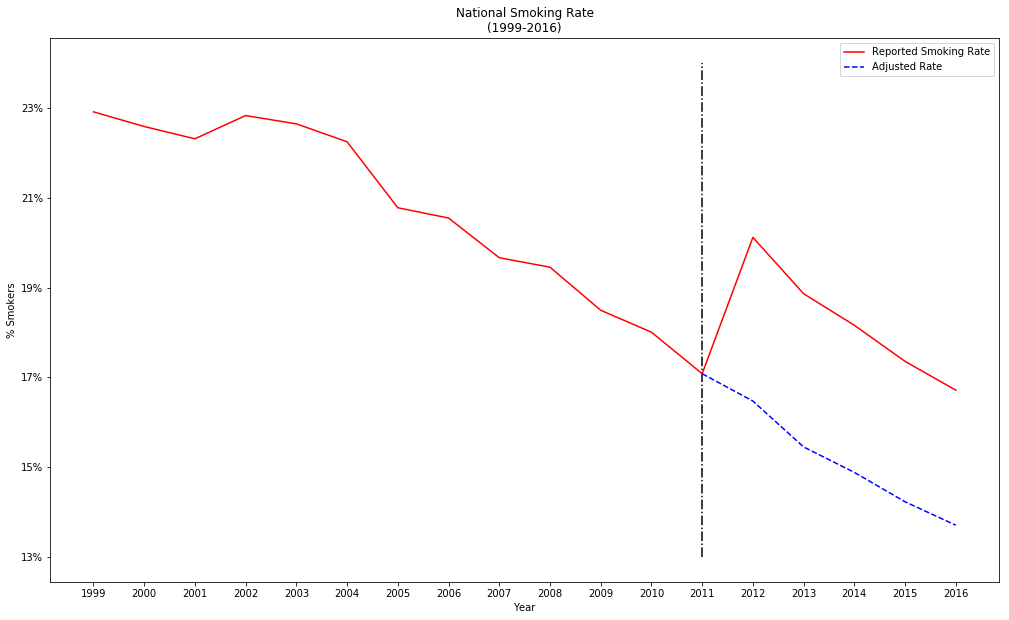

In [153]:
plt.figure(figsize=(17, 10))

plt.plot(mean_smoking_df['Smoking_unadj'], c='r', label = 'Reported Smoking Rate')
plt.plot(mean_smoking_df['Smoking'][mean_smoking_df.index >= 2011], c='b', linestyle = '--', label = 'Adjusted Rate')
plt.vlines(2011, .13, .24, linestyles='-.')

plt.xticks(np.arange(1999, 2017))
plt.yticks(np.arange(.13, .24, .02), labels = [f'{i}%' for i in range(13, 24, 2)])
plt.xlabel('Year')
plt.ylabel('% Smokers')
plt.title('National Smoking Rate\n(1999-2016)')
plt.legend()
plt.show()

<a id='diabetes'></a>
#### 4. Diabetes
Deaths to diabetes used as proxy to estimate rates of diabetes. Symptoms related to diabetes might contribute to heart disease deaths.

In [154]:
diabetes_df = df[df['Cause_Name']=='Diabetes'][['Year', 'State', 'Deaths']]
diabetes_df.head()

,Year,State,Deaths
3795,2016,Alabama,1183
3796,2015,Alabama,1255
3797,2014,Alabama,1281
3798,2013,Alabama,1349
3799,2012,Alabama,1300


In [155]:
# Append diabetes death rate data to primary dataframe
diab_list = []

for yr, st in zip(hd_df['Year'], hd_df['State']):   
    diab_rate = diabetes_df['Deaths'][(diabetes_df['State'] == st) & (diabetes_df['Year'] == yr)].values[0]
    diab_list.append(diab_rate)
    
hd_df['Diabetes'] = np.array(diab_list) / hd_df['Population']
hd_df.head()

,Year,Cause_Name,State,Deaths,Population,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,...,years_85,years_1,Sq_Miles,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Diabetes
4731,2016,Heart disease,Alabama,12832,4860545,0.484347,0.048362,0.063089,0.066052,0.069107,...,0.017883,0.012039,50750.0,95.774286,2.01,1.09,0.26,0.65,0.188127,0.000243
4732,2015,Heart disease,Alabama,12981,4850858,0.484665,0.048409,0.063828,0.065925,0.071293,...,0.017619,0.012179,50750.0,95.583409,2.01,1.11,0.26,0.64,0.185489,0.000259
4733,2014,Heart disease,Alabama,12461,4840037,0.484787,0.048594,0.064846,0.065804,0.073148,...,0.017302,0.012057,50750.0,95.370187,2.00,1.13,0.25,0.62,0.189006,0.000265
4734,2013,Heart disease,Alabama,12472,4827660,0.484981,0.049125,0.065616,0.066477,0.073858,...,0.016942,0.011886,50750.0,95.126305,1.99,1.14,0.25,0.60,0.209225,0.000279
4735,2012,Heart disease,Alabama,12036,4813946,0.485060,0.049996,0.066419,0.067235,0.073380,...,0.016657,0.012156,50750.0,94.856079,2.00,1.16,0.24,0.60,0.213620,0.000270


<a id='target'></a>
#### 4. Calculate Target Variable (Deaths_per_Capita)

In [156]:
hd_df['Deaths_per_Capita'] = hd_df['Deaths'] / hd_df['Population']

# Set index based on state & year
hd_df['State_Year'] = hd_df['State'] + '_' + hd_df['Year'].astype(str)
hd_df = hd_df.set_index(hd_df['State_Year'])

hd_df = hd_df.drop(columns=['Cause_Name', 'Deaths', 'Population', 'Sq_Miles', 'State_Year', 'State', 'Year'])
hd_df.head()

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_85,years_1,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Diabetes,Deaths_per_Capita
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,0.484347,0.048362,0.063089,0.066052,0.069107,0.068337,0.062332,0.061698,0.060430,0.064118,...,0.017883,0.012039,95.774286,2.01,1.09,0.26,0.65,0.188127,0.000243,0.002640
Alabama_2015,0.484665,0.048409,0.063828,0.065925,0.071293,0.066776,0.062877,0.060945,0.062719,0.063660,...,0.017619,0.012179,95.583409,2.01,1.11,0.26,0.64,0.185489,0.000259,0.002676
Alabama_2014,0.484787,0.048594,0.064846,0.065804,0.073148,0.065357,0.063535,0.060410,0.064354,0.064367,...,0.017302,0.012057,95.370187,2.00,1.13,0.25,0.62,0.189006,0.000265,0.002575
Alabama_2013,0.484981,0.049125,0.065616,0.066477,0.073858,0.064491,0.063740,0.060343,0.065373,0.066067,...,0.016942,0.011886,95.126305,1.99,1.14,0.25,0.60,0.209225,0.000279,0.002583
Alabama_2012,0.485060,0.049996,0.066419,0.067235,0.073380,0.064310,0.063665,0.060729,0.065673,0.068068,...,0.016657,0.012156,94.856079,2.00,1.16,0.24,0.60,0.213620,0.000270,0.002500


<a id='transform'></a>

### Explore Data

In [157]:
hd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, Alabama_2016 to Wyoming_1999
Data columns (total 28 columns):
Percent_Male         918 non-null float64
years_1_4            918 non-null float64
years_10_14          918 non-null float64
years_15_19          918 non-null float64
years_20_24          918 non-null float64
years_25_29          918 non-null float64
years_30_34          918 non-null float64
years_35_39          918 non-null float64
years_40_44          918 non-null float64
years_45_49          918 non-null float64
years_5_9            918 non-null float64
years_50_54          918 non-null float64
years_55_59          918 non-null float64
years_60_64          918 non-null float64
years_65_69          918 non-null float64
years_70_74          918 non-null float64
years_75_79          918 non-null float64
years_80_84          918 non-null float64
years_85             918 non-null float64
years_1              918 non-null float64
Pop_Density          918 non-null float6

In [158]:
hd_df.describe()

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_85,years_1,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Diabetes,Deaths_per_Capita
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,...,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,0.492744,0.052031,0.068364,0.070826,0.071147,0.066853,0.066474,0.067752,0.070885,0.071844,...,0.017429,0.013093,360.544804,2.407505,1.233475,0.375556,0.798475,0.197257,0.000250,0.002135
std,0.008036,0.005694,0.006572,0.005593,0.006883,0.008315,0.006813,0.007635,0.008322,0.006688,...,0.004132,0.001638,1225.170591,0.531311,0.217358,0.195609,0.277674,0.044162,0.000056,0.000481
min,0.470729,0.038622,0.038807,0.053589,0.054894,0.049994,0.053501,0.053990,0.052107,0.051264,...,0.003939,0.009192,1.094872,1.250000,0.630000,0.100000,0.360000,0.066968,0.000107,0.000883
25%,0.487136,0.048655,0.064776,0.066984,0.067824,0.062663,0.062372,0.061818,0.064088,0.067681,...,0.014708,0.012157,43.020646,2.080000,1.090000,0.220000,0.630000,0.167110,0.000214,0.001812
50%,0.491545,0.051847,0.068489,0.070818,0.070614,0.065976,0.065398,0.066532,0.070497,0.072660,...,0.017298,0.013024,99.558002,2.330000,1.220000,0.330000,0.740000,0.201000,0.000248,0.002092
75%,0.497149,0.055118,0.072434,0.073652,0.073300,0.070254,0.069804,0.073273,0.077734,0.076092,...,0.020400,0.013939,223.290201,2.590000,1.380000,0.500000,0.890000,0.228000,0.000283,0.002472
max,0.523698,0.077162,0.090548,0.099466,0.104689,0.123434,0.113322,0.092383,0.094693,0.088377,...,0.027776,0.020272,10013.696225,4.770000,1.900000,1.190000,2.000000,0.326000,0.000470,0.003765


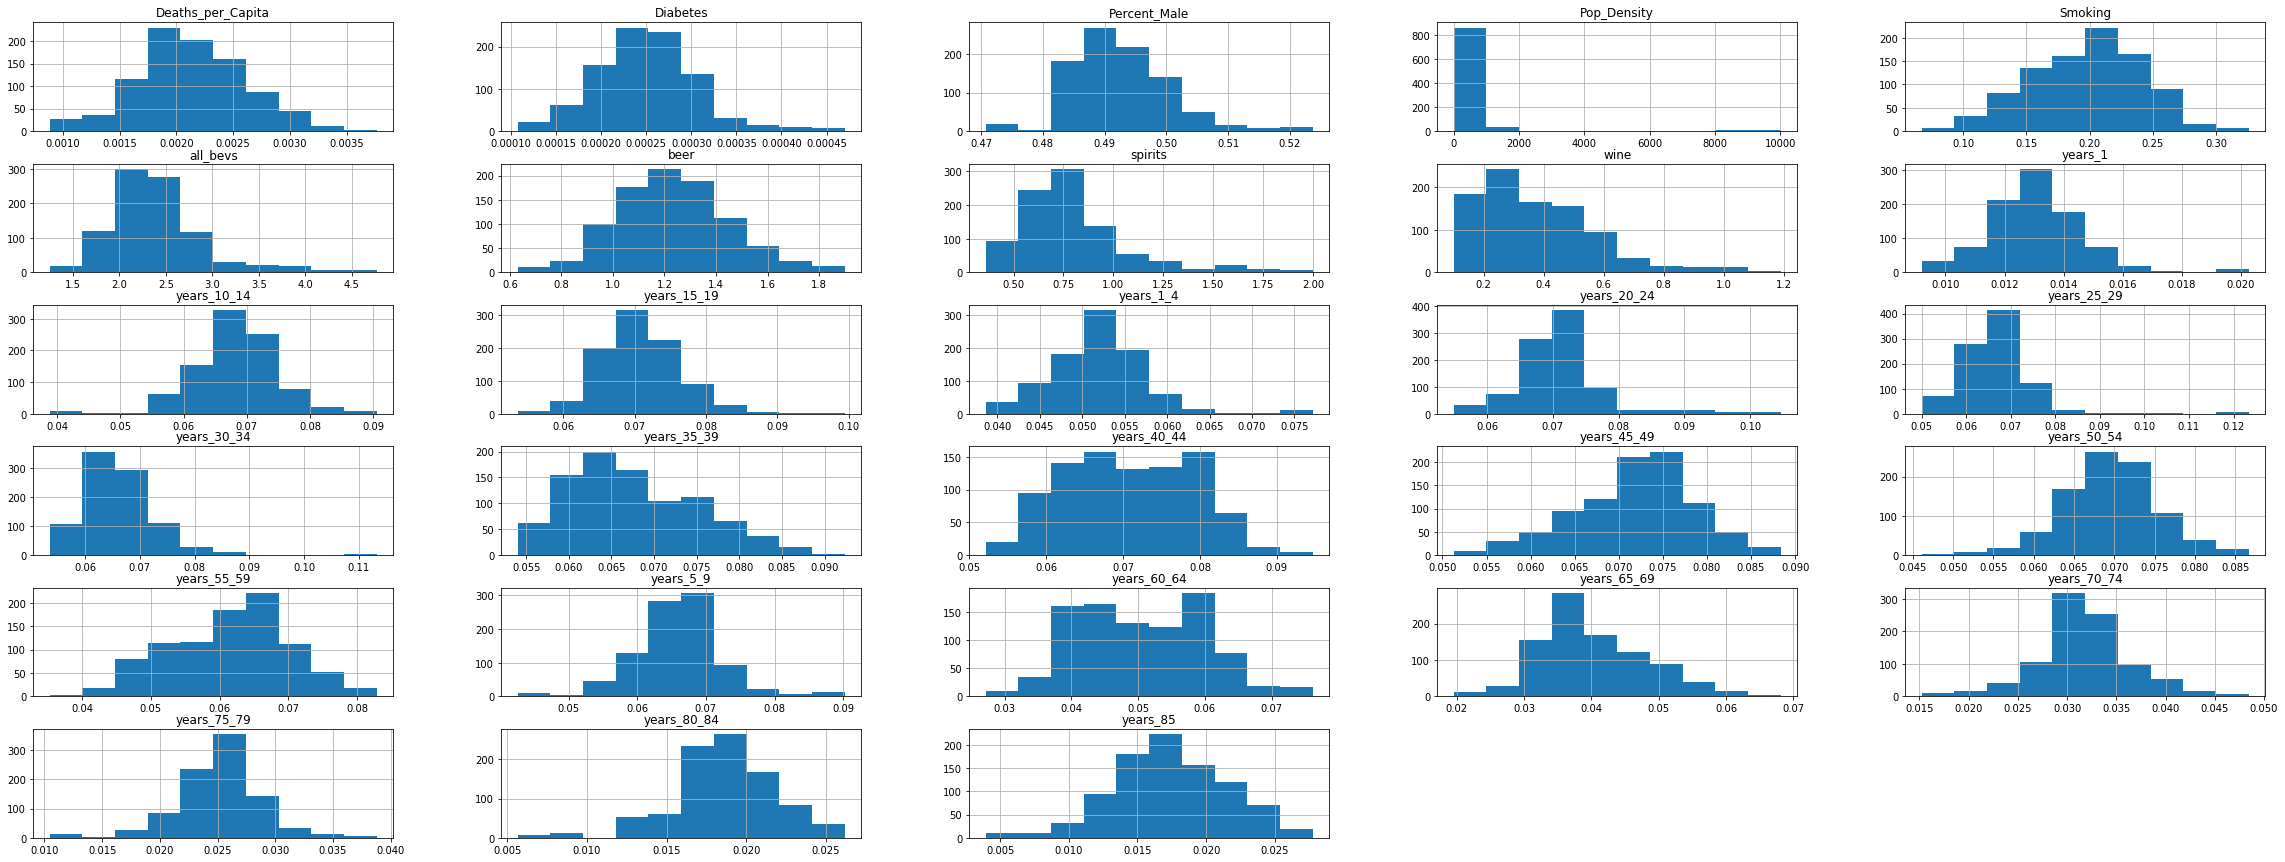

In [159]:
# View feature distributions
hd_df.hist(figsize = (40, 15))
plt.show()

Slight skewness throughout. Perform log normalization and re-check distributions.

<function matplotlib.pyplot.show(*args, **kw)>

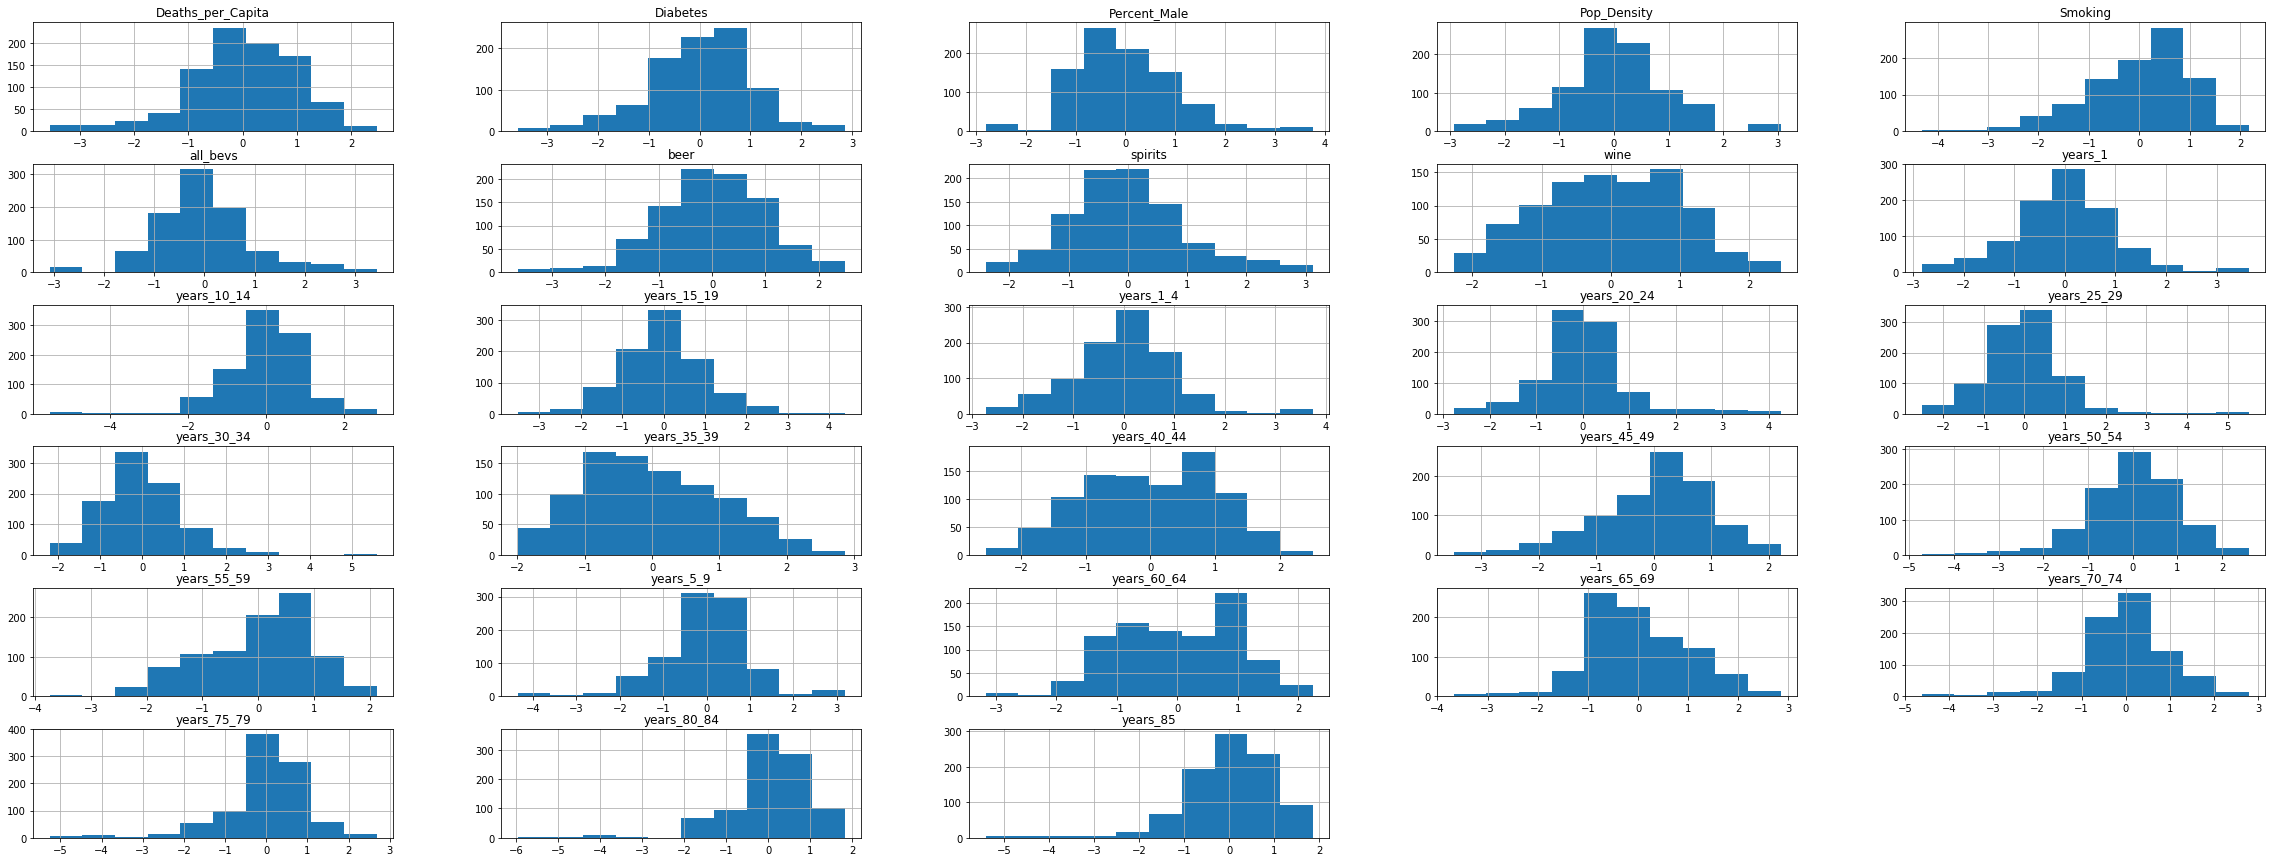

In [160]:
from sklearn import preprocessing

log_df = pd.DataFrame()
for col in hd_df.columns:
    log_df[col] = np.log(hd_df[col])
#     hd_df[col] = (hd_df[col] - hd_df[col].min())/(hd_df[col].max() - hd_df[col].min())
#     hd_df = hd_df.rename(columns = {col:f'log_norm_{col}'})  

transformed_df = pd.DataFrame(preprocessing.scale(log_df), columns = log_df.columns).set_index(hd_df.index)

transformed_df.hist(figsize=(40, 15))
plt.show

In [161]:
def coll_check(data, size=(11,9)):
    # Create a covariance matrix
    corr = data.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize = size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, vmin=-.4, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
#     plt.savefig('cov_matrix_' + str(len(data.columns)) + '_inputs.png', dpi=100)

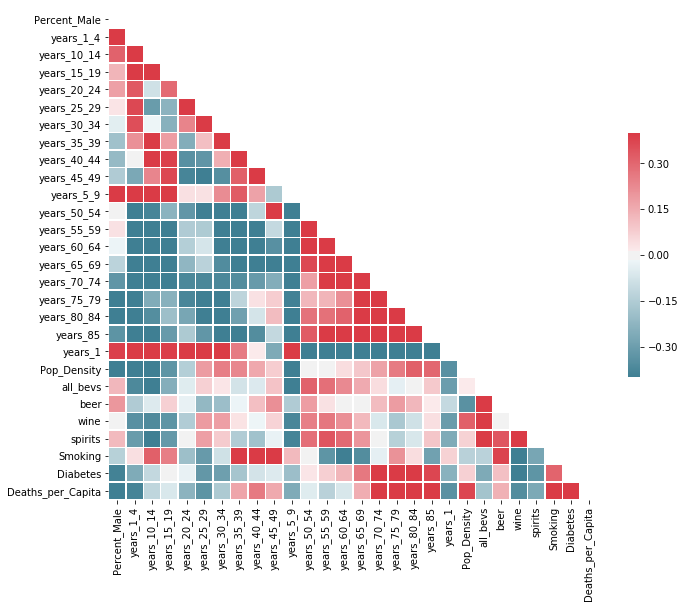

In [164]:
coll_check(transformed_df)

<a id='linreg'></a>
### Regression Analysis

In [163]:
# Explore combinations of 8 predictor variables for regression analysis
from itertools import combinations as comb

combs = list(comb(transformed_df.columns[:-4], 8))
predictors = transformed_df.columns[:-4]

len(combs)

735471

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(transformed_df.drop(columns=['Deaths_per_Capita']), 
                                                    transformed_df['Deaths_per_Capita'],
                                                    test_size = .25, 
                                                    random_state = 123)

best_model = {'Features': [], 'RMSE': 10**1000000}
i = 1
t0 = time.time()
t2 = time.time()
for c in combs:


    linreg = LinearRegression()
    linreg.fit(X_train[list(c)], y_train)
    y_preds = linreg.predict(X_test[list(c)])
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    if rmse < best_model['RMSE']:
        best_model['Features'] = list(c)
        best_model['RMSE'] = rmse
    if i % np.round((len(combs) * .1), 0) == 0:
        t1 = time.time()
        print(f'{100 * i/len(combs):.2f}% Complete')
        print(f'Total Time: {t1 - t0:.2f}s')
        print(f'Lap Time: {t1 - t2:.2f}s \n')
        t2 = time.time()
        
    i += 1
    
best_model

10.00% Complete
Total Time: 155.67s
Lap Time: 155.67s 

20.00% Complete
Total Time: 302.61s
Lap Time: 146.94s 

30.00% Complete
Total Time: 454.89s
Lap Time: 152.28s 

40.00% Complete
Total Time: 607.48s
Lap Time: 152.59s 

50.00% Complete
Total Time: 763.36s
Lap Time: 155.88s 

60.00% Complete
Total Time: 920.87s
Lap Time: 157.51s 

70.00% Complete
Total Time: 1074.15s
Lap Time: 153.28s 

80.00% Complete
Total Time: 1229.79s
Lap Time: 155.63s 

90.00% Complete
Total Time: 1381.41s
Lap Time: 151.62s 

100.00% Complete
Total Time: 1531.75s
Lap Time: 150.34s 



{'Features': ['Percent_Male',
  'years_30_34',
  'years_50_54',
  'years_65_69',
  'years_70_74',
  'years_75_79',
  'all_bevs',
  'wine'],
 'RMSE': 0.4235757535327787}

In [170]:
import statsmodels.formula.api as smf

predictors = ['Percent_Male', 'years_75_79', 'wine', 'Smoking']

f = 'Deaths_per_Capita~'
for predictor in predictors:
    f += '+' + predictor
model = smf.ols(formula=f, data=transformed_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Deaths_per_Capita   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1153.
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        15:39:40   Log-Likelihood:                -476.10
No. Observations:                 918   AIC:                             962.2
Df Residuals:                     913   BIC:                             986.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.816e-17      0.013   2.84e-15   

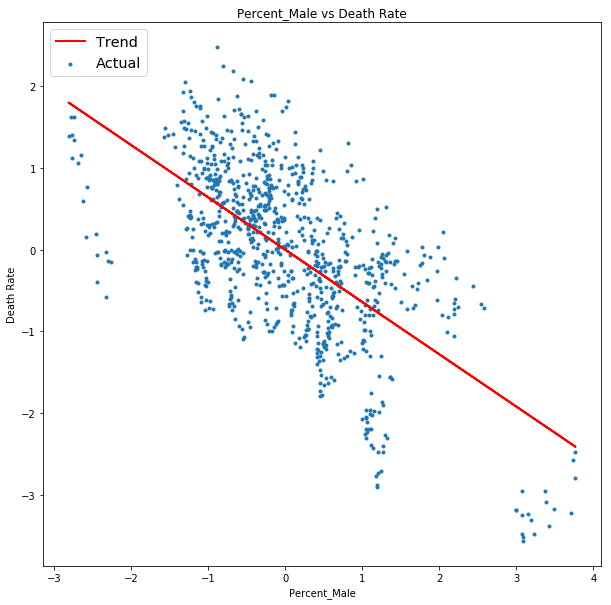

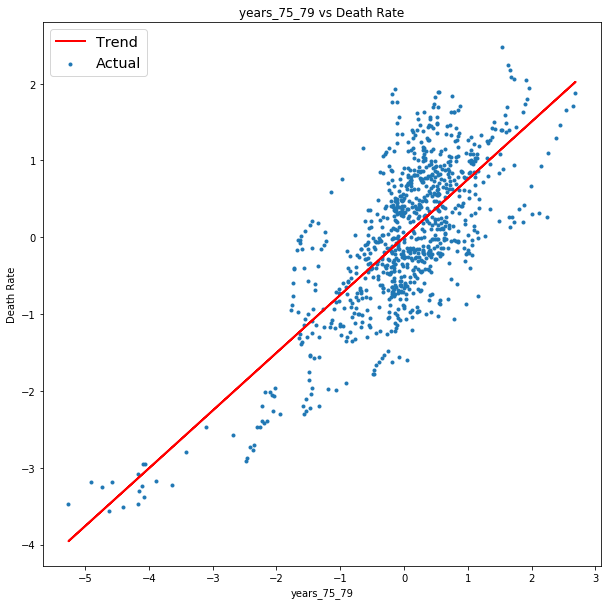

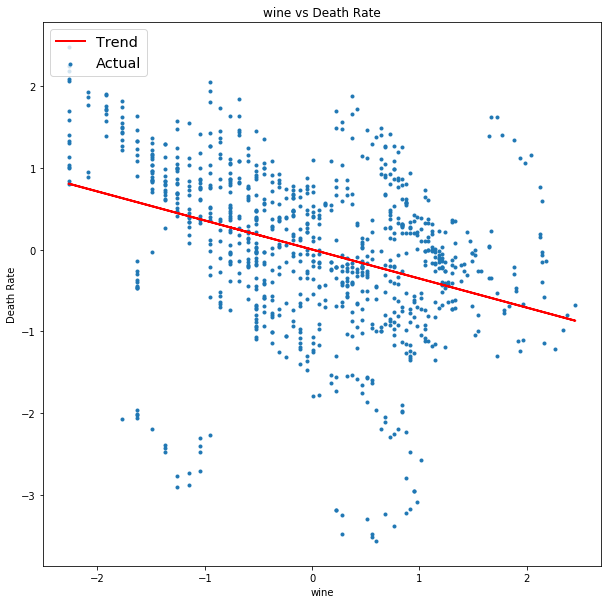

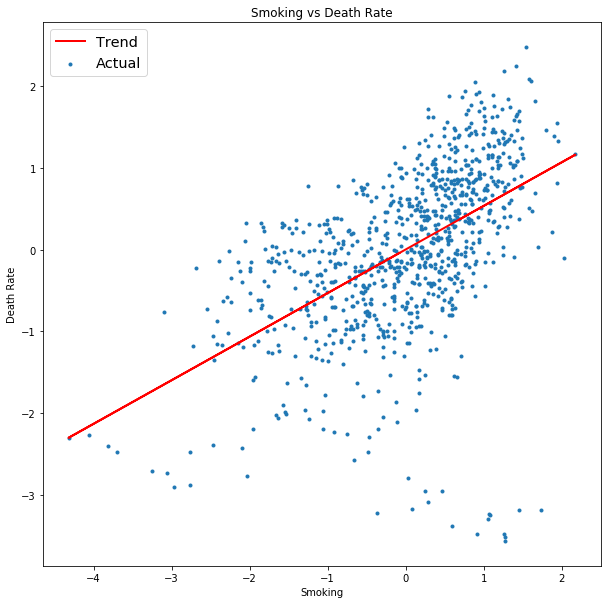

,Variable,R Squared,Intercept,Slope,P Value
0,Percent_Male,0.409124,3.816392e-17,-0.639628,9.108390e-107
1,years_75_79,0.565296,3.816392e-17,0.751862,6.873118e-168
2,wine,0.125982,3.816392e-17,-0.354940,1.212843e-28
3,Smoking,0.283746,3.816392e-17,0.532678,2.060946e-68


In [171]:
results = [['Variable', 'R Squared', 'Intercept', 'Slope', 'P Value']]

for predictor in predictors:
    f = 'Deaths_per_Capita~' + predictor
    model = smf.ols(formula=f, data=transformed_df).fit()
    results.append([predictor, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
    y_pred = model.predict()
    plt.figure(figsize=(10, 10))
    plt.title(predictor + ' vs Death Rate')
    plt.xlabel(predictor)
    plt.ylabel('Death Rate')
    plt.scatter(transformed_df[predictor], transformed_df['Deaths_per_Capita'], marker='.', label='Actual')
    plt.plot(transformed_df[predictor], y_pred, color='r', lw=2, label='Trend')
    plt.legend(loc=2, fontsize='x-large')
    plt.show()
#     plt.savefig('scatter_log_' + f + '.png', dpi=100)

result_df = pd.DataFrame(results[1:],columns=results[0])
result_df

<a id='linreg_obs'></a>
### Observations
Demographic data clearly has the largest effect on deaths to heart disease, particularly with regard to ages 70+ and gender. Smoking also has a clear impact, though it was surprising to see that alcohol consumption seems to have a negative relationship. However, negative collinearity was observed between smoking and wine consumption, making these variables difficult to disentangle.

<a id='classify'></a>
## Create Classification Targets
Base risk levels on previous 15 years of data:
* **High Risk:** Top 33% of death rates
* **Medium Risk:** Middle 33% of death rates
* **Low Risk:** Lowest 33% of death rates

In [174]:
transformed_df.head()

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_85,years_1,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Diabetes,Deaths_per_Capita
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.629633,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,-1.290327,-1.141212,...,0.216467,-0.624540,0.002169,-0.771982,-0.599453,-0.447217,-0.498100,-0.080491,-0.012987,0.996612
Alabama_2015,-1.011486,-0.620650,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,-0.976052,-1.216046,...,0.161113,-0.529570,0.000858,-0.771982,-0.498350,-0.447217,-0.548017,-0.138447,0.253152,1.052941
Alabama_2014,-0.995961,-0.584884,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,-0.758437,-1.100778,...,0.093588,-0.612363,-0.000609,-0.796258,-0.399053,-0.521983,-0.650235,-0.061352,0.352235,0.892148
Alabama_2013,-0.971242,-0.483217,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,-0.625660,-0.828431,...,0.015390,-0.728990,-0.002291,-0.820656,-0.350062,-0.521983,-0.755805,0.355870,0.588770,0.906471
Alabama_2012,-0.961257,-0.318997,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,-0.586887,-0.516959,...,-0.047637,-0.545397,-0.004159,-0.796258,-0.253356,-0.599801,-0.755805,0.441220,0.439944,0.770267


In [175]:
hd_classify_df = transformed_df
hd_classify_df['Year'] = hd_classify_df.index.astype(str).str[-4:].astype(int)
hd_classify_df['State'] = hd_classify_df.index.astype(str).str[:-5]
hd_classify_df['Risk_Level'] = pd.qcut(hd_classify_df['Deaths_per_Capita'], 3, labels=[1, 2, 3]).astype(int)
hd_classify_df = hd_classify_df.drop(columns=['Deaths_per_Capita'])
hd_classify_df.head(5)

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Diabetes,Year,State,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.629633,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,-1.290327,-1.141212,...,0.002169,-0.771982,-0.599453,-0.447217,-0.498100,-0.080491,-0.012987,2016,Alabama,3
Alabama_2015,-1.011486,-0.620650,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,-0.976052,-1.216046,...,0.000858,-0.771982,-0.498350,-0.447217,-0.548017,-0.138447,0.253152,2015,Alabama,3
Alabama_2014,-0.995961,-0.584884,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,-0.758437,-1.100778,...,-0.000609,-0.796258,-0.399053,-0.521983,-0.650235,-0.061352,0.352235,2014,Alabama,3
Alabama_2013,-0.971242,-0.483217,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,-0.625660,-0.828431,...,-0.002291,-0.820656,-0.350062,-0.521983,-0.755805,0.355870,0.588770,2013,Alabama,3
Alabama_2012,-0.961257,-0.318997,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,-0.586887,-0.516959,...,-0.004159,-0.796258,-0.253356,-0.599801,-0.755805,0.441220,0.439944,2012,Alabama,3


In [177]:
hd_classify_df[hd_classify_df['Year']==2016][['State', 'Risk_Level']].set_index(['State']).to_csv('2016_results.csv')

In [178]:
hd_classify_df.describe()

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_1,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Diabetes,Year,Risk_Level
count,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,...,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,9.180000e+02,918.000000,918.000000
mean,5.210792e-15,2.806095e-16,3.924965e-15,-2.147399e-15,-8.592739e-16,-1.469050e-15,1.304693e-15,-4.525550e-16,-1.972037e-15,-2.442491e-15,...,5.434167e-15,-9.215577e-17,2.915847e-16,-3.144423e-17,1.487554e-16,1.753620e-16,-8.928951e-16,4.738282e-15,2007.500000,2.000000
std,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,...,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,1.000545e+00,5.190956,0.816942
min,-2.810795e+00,-2.732704e+00,-5.557939e+00,-3.529691e+00,-2.778398e+00,-2.528145e+00,-2.208127e+00,-1.998725e+00,-2.543355e+00,-3.477565e+00,...,-2.829362e+00,-2.935043e+00,-3.083963e+00,-3.647780e+00,-2.268694e+00,-2.400462e+00,-4.320728e+00,-3.584386e+00,1999.000000,1.000000
25%,-6.977848e-01,-5.732945e-01,-4.852468e-01,-6.746264e-01,-4.738053e-01,-5.168749e-01,-6.125476e-01,-7.734949e-01,-7.934892e-01,-5.764183e-01,...,-5.446094e-01,-5.235536e-01,-6.053544e-01,-5.994526e-01,-7.656696e-01,-5.987204e-01,-5.668016e-01,-5.690472e-01,2003.000000,1.000000
50%,-1.421054e-01,2.096768e-02,6.653786e-02,3.780706e-02,-3.456223e-02,-5.811694e-02,-1.198818e-01,-1.085366e-01,1.230408e-02,1.647868e-01,...,1.832297e-02,2.762095e-02,-5.290045e-02,2.706406e-02,7.262391e-03,-8.058823e-02,1.912323e-01,6.380597e-02,2007.500000,2.000000
75%,5.569931e-01,5.931760e-01,6.210985e-01,5.398200e-01,3.721007e-01,5.013090e-01,5.582369e-01,7.647048e-01,8.386348e-01,6.467719e-01,...,5.735314e-01,5.582144e-01,4.620220e-01,7.122964e-01,7.993532e-01,5.136583e-01,7.086542e-01,6.391921e-01,2012.000000,3.000000
max,3.765588e+00,3.739173e+00,2.831098e+00,4.384961e+00,4.255778e+00,5.519756e+00,5.597724e+00,2.861815e+00,2.507099e+00,2.209778e+00,...,3.633933e+00,3.056544e+00,3.434499e+00,2.490373e+00,2.452294e+00,3.120511e+00,2.176474e+00,2.857276e+00,2016.000000,3.000000


<a id='featlag'></a>
### Create 1 - 5 Year Lags for Features
To base estimates of risk levels on data from the same year is not particularly helpful. For example, data for 2015 does not become available until 2016, as will death counts. While this data is useful for descriptive measures, it does not help in making predictions, so the objective is to make predictions for 2016 data based on 2014 data and prior. Lags will be created for 1 - 5 years, though lags for years 3 - 5 are all that will be considered for model training and testing.

In [179]:
lag_df = hd_classify_df[hd_classify_df['Year']>2003]
lag_df[lag_df['State'] == 'New York']

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,Pop_Density,all_bevs,beer,wine,spirits,Smoking,Diabetes,Year,State,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
New York_2016,-0.919288,-0.849602,-1.607394,-1.612954,-0.153143,1.274673,0.668162,-0.444013,-1.342704,-0.795637,...,0.973304,-0.288294,-1.603054,0.910430,0.088904,-1.822010,-0.791516,2016,New York,2
New York_2015,-0.952454,-0.774095,-1.499181,-1.487802,0.062103,1.192576,0.571097,-0.555472,-1.084585,-0.676718,...,0.972743,-0.376795,-1.664497,0.799353,0.047360,-2.043967,-0.780247,2015,New York,2
New York_2014,-0.973160,-0.736934,-1.365138,-1.312458,0.293894,1.078204,0.526377,-0.667404,-0.820629,-0.517146,...,0.971224,-0.332343,-1.664497,0.910430,0.005273,-1.460313,-0.749753,2014,New York,2
New York_2013,-0.986310,-0.782672,-1.266299,-1.026928,0.376678,0.958089,0.454388,-0.737465,-0.569774,-0.237687,...,0.969192,-0.310269,-1.482169,0.837103,0.047360,-1.560445,-0.704227,2013,New York,2
New York_2012,-1.014355,-0.781678,-1.152122,-0.723491,0.416794,0.850139,0.314836,-0.760024,-0.346305,0.040389,...,0.966283,-0.399174,-1.603054,0.837103,-0.037371,-1.105175,-0.775265,2012,New York,2
New York_2011,-1.060145,-0.800766,-1.010034,-0.420499,0.405304,0.760602,0.176800,-0.686582,-0.183425,0.282972,...,0.962960,-0.535653,-1.726625,0.799353,-0.168802,-0.875625,-0.777192,2011,New York,2
New York_2010,-1.097710,-0.775333,-0.874163,-0.098233,0.315600,0.647059,0.013449,-0.419779,-0.082700,0.499621,...,0.958870,-0.582009,-1.726625,0.721535,-0.213832,-0.261768,-1.145533,2010,New York,2
New York_2009,-1.123717,-0.764496,-0.711203,0.163376,0.166721,0.610340,-0.119270,-0.105637,0.062992,0.652253,...,0.955540,-0.605354,-1.542283,0.681401,-0.259501,-0.544997,-1.027594,2009,New York,3
New York_2008,-1.130821,-0.749815,-0.515160,0.316944,0.019668,0.553036,-0.249631,0.191376,0.321960,0.689059,...,0.952313,-0.605354,-1.482169,0.681401,-0.352830,-0.061475,-1.146529,2008,New York,3


In [180]:
lag_tags = {}
for i in range(5):
    lag_tags[f'lag_{i + 1}'] = hd_classify_df[(hd_classify_df['Year'] >= 2003 - i) & (hd_classify_df['Year'] < 2016 - i)]
lag_tags.keys()

dict_keys(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'])

In [181]:
i = 1
for k in lag_tags.keys():
    rename = {}
    for col in lag_tags[k].columns:
        rename[col] = f'{col}_lag_{i}'
    lag_tags[k] = lag_tags[k].rename(columns=rename)
    i+=1
    
lag_tags['lag_1'].shape, lag_df.shape

((663, 30), (663, 30))

In [182]:
for k in lag_tags.keys():
    for col in lag_tags[k].columns[:-3]:
        lag_df[col] = list(lag_tags[k][col])
        
lag_df.head(13)

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_80_84_lag_5,years_85_lag_5,years_1_lag_5,Pop_Density_lag_5,all_bevs_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,Smoking_lag_5,Diabetes_lag_5
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.629633,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,-1.290327,-1.141212,...,0.135407,-0.143233,-0.431463,-0.006250,-0.845177,-0.253356,-0.599801,-0.809918,0.543322,0.379440
Alabama_2015,-1.011486,-0.620650,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,-0.976052,-1.216046,...,0.103197,-0.213527,-0.391786,-0.008042,-0.845177,-0.205626,-0.680932,-0.864955,0.654280,0.472395
Alabama_2014,-0.995961,-0.584884,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,-0.758437,-1.100778,...,0.079633,-0.286688,-0.004613,-0.011847,-0.845177,-0.111378,-0.765670,-0.920950,0.580642,0.351297
Alabama_2013,-0.971242,-0.483217,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,-0.625660,-0.828431,...,0.120536,-0.343127,0.327165,-0.017355,-0.771982,0.027064,-0.765670,-0.920950,0.654280,0.806606
Alabama_2012,-0.961257,-0.318997,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,-0.586887,-0.516959,...,0.085952,-0.394096,0.288880,-0.023702,-0.796258,0.072456,-0.765670,-1.035948,0.780051,0.612936
Alabama_2011,-0.949256,-0.174352,-0.149929,-0.343002,0.212893,-0.245984,-0.443047,-0.782127,-0.606639,-0.187623,...,0.067667,-0.446071,0.090635,-0.029897,-0.919491,-0.018701,-0.854350,-1.095025,1.053832,1.095506
Alabama_2010,-0.913513,-0.097636,-0.166654,0.110520,-0.039701,-0.188210,-0.579360,-0.450187,-0.659430,0.096046,...,0.077824,-0.501016,0.005618,-0.038349,-1.020373,-0.158302,-0.947358,-1.155206,1.070352,1.078994
Alabama_2009,-0.910658,-0.095946,-0.142015,0.399590,-0.160517,-0.106746,-0.732784,-0.216639,-0.549569,0.241411,...,0.093072,-0.574748,0.007161,-0.043990,-1.020373,-0.111378,-0.947358,-1.216534,1.135775,1.176978
Alabama_2008,-0.979136,-0.117594,-0.045621,0.468782,-0.180140,-0.051921,-0.863394,-0.109799,-0.347343,0.325743,...,0.051319,-0.548674,-0.070181,-0.047951,-1.045924,-0.111378,-1.045138,-1.216534,0.987079,1.096709


In [185]:
lag_df['risk_level'] = lag_df['Risk_Level']
lag_df = lag_df.drop(columns=['Risk_Level', 'Year', 'State'])
lag_df = lag_df.rename(columns={'risk_level': 'Risk_Level'})

# Save final dataframe to csv
lag_df.to_csv('final_dataset.csv')

In [186]:
lag_df.head()

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_85_lag_5,years_1_lag_5,Pop_Density_lag_5,all_bevs_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,Smoking_lag_5,Diabetes_lag_5,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.629633,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,-1.290327,-1.141212,...,-0.143233,-0.431463,-0.006250,-0.845177,-0.253356,-0.599801,-0.809918,0.543322,0.379440,3
Alabama_2015,-1.011486,-0.620650,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,-0.976052,-1.216046,...,-0.213527,-0.391786,-0.008042,-0.845177,-0.205626,-0.680932,-0.864955,0.654280,0.472395,3
Alabama_2014,-0.995961,-0.584884,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,-0.758437,-1.100778,...,-0.286688,-0.004613,-0.011847,-0.845177,-0.111378,-0.765670,-0.920950,0.580642,0.351297,3
Alabama_2013,-0.971242,-0.483217,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,-0.625660,-0.828431,...,-0.343127,0.327165,-0.017355,-0.771982,0.027064,-0.765670,-0.920950,0.654280,0.806606,3
Alabama_2012,-0.961257,-0.318997,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,-0.586887,-0.516959,...,-0.394096,0.288880,-0.023702,-0.796258,0.072456,-0.765670,-1.035948,0.780051,0.612936,3


<a id='mlm'></a>
## Machine Learning Models

In [188]:
lag_df = pd.read_csv('final_dataset.csv', index_col=0)
lag_df.head(14)

,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_85_lag_5,years_1_lag_5,Pop_Density_lag_5,all_bevs_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,Smoking_lag_5,Diabetes_lag_5,Risk_Level
State_Year,,,,,,,,,,,,,,,,,,,,,
Alabama_2016,-1.051999,-0.629633,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,-1.290327,-1.141212,...,-0.143233,-0.431463,-0.006250,-0.845177,-0.253356,-0.599801,-0.809918,0.543322,0.379440,3
Alabama_2015,-1.011486,-0.620650,-0.631186,-0.878474,0.069591,0.049265,-0.528689,-0.902241,-0.976052,-1.216046,...,-0.213527,-0.391786,-0.008042,-0.845177,-0.205626,-0.680932,-0.864955,0.654280,0.472395,3
Alabama_2014,-0.995961,-0.584884,-0.474629,-0.901903,0.349599,-0.141977,-0.420392,-0.982091,-0.758437,-1.100778,...,-0.286688,-0.004613,-0.011847,-0.845177,-0.111378,-0.765670,-0.920950,0.580642,0.351297,3
Alabama_2013,-0.971242,-0.483217,-0.357680,-0.771869,0.454747,-0.260817,-0.386999,-0.992035,-0.625660,-0.828431,...,-0.343127,0.327165,-0.017355,-0.771982,0.027064,-0.765670,-0.920950,0.654280,0.806606,3
Alabama_2012,-0.961257,-0.318997,-0.237271,-0.626588,0.383969,-0.285822,-0.399239,-0.934386,-0.586887,-0.516959,...,-0.394096,0.288880,-0.023702,-0.796258,0.072456,-0.765670,-1.035948,0.780051,0.612936,3
Alabama_2011,-0.949256,-0.174352,-0.149929,-0.343002,0.212893,-0.245984,-0.443047,-0.782127,-0.606639,-0.187623,...,-0.446071,0.090635,-0.029897,-0.919491,-0.018701,-0.854350,-1.095025,1.053832,1.095506,3
Alabama_2010,-0.913513,-0.097636,-0.166654,0.110520,-0.039701,-0.188210,-0.579360,-0.450187,-0.659430,0.096046,...,-0.501016,0.005618,-0.038349,-1.020373,-0.158302,-0.947358,-1.155206,1.070352,1.078994,3
Alabama_2009,-0.910658,-0.095946,-0.142015,0.399590,-0.160517,-0.106746,-0.732784,-0.216639,-0.549569,0.241411,...,-0.574748,0.007161,-0.043990,-1.020373,-0.111378,-0.947358,-1.216534,1.135775,1.176978,3
Alabama_2008,-0.979136,-0.117594,-0.045621,0.468782,-0.180140,-0.051921,-0.863394,-0.109799,-0.347343,0.325743,...,-0.548674,-0.070181,-0.047951,-1.045924,-0.111378,-1.045138,-1.216534,0.987079,1.096709,3


<a id='featheat'></a>
### Split Data Into Target & Feature Sets
**Features** set to drop same year and 1 year lag columns. Results for prior year are generally available 6 months into the next year. As such, these columns will not be of practical use for making predictions and are therefore not to be included in the feature set.

In [190]:
features = lag_df.drop(columns=lag_df.columns[:81])
features = features.drop(columns=['Risk_Level'])
target = lag_df['Risk_Level']

In [191]:
features.columns

Index(['Percent_Male_lag_3', 'years_1_4_lag_3', 'years_10_14_lag_3',
       'years_15_19_lag_3', 'years_20_24_lag_3', 'years_25_29_lag_3',
       'years_30_34_lag_3', 'years_35_39_lag_3', 'years_40_44_lag_3',
       'years_45_49_lag_3', 'years_5_9_lag_3', 'years_50_54_lag_3',
       'years_55_59_lag_3', 'years_60_64_lag_3', 'years_65_69_lag_3',
       'years_70_74_lag_3', 'years_75_79_lag_3', 'years_80_84_lag_3',
       'years_85_lag_3', 'years_1_lag_3', 'Pop_Density_lag_3',
       'all_bevs_lag_3', 'beer_lag_3', 'wine_lag_3', 'spirits_lag_3',
       'Smoking_lag_3', 'Diabetes_lag_3', 'Percent_Male_lag_4',
       'years_1_4_lag_4', 'years_10_14_lag_4', 'years_15_19_lag_4',
       'years_20_24_lag_4', 'years_25_29_lag_4', 'years_30_34_lag_4',
       'years_35_39_lag_4', 'years_40_44_lag_4', 'years_45_49_lag_4',
       'years_5_9_lag_4', 'years_50_54_lag_4', 'years_55_59_lag_4',
       'years_60_64_lag_4', 'years_65_69_lag_4', 'years_70_74_lag_4',
       'years_75_79_lag_4', 'years_80_84

#### Inspect Feature Correlation Heat Map

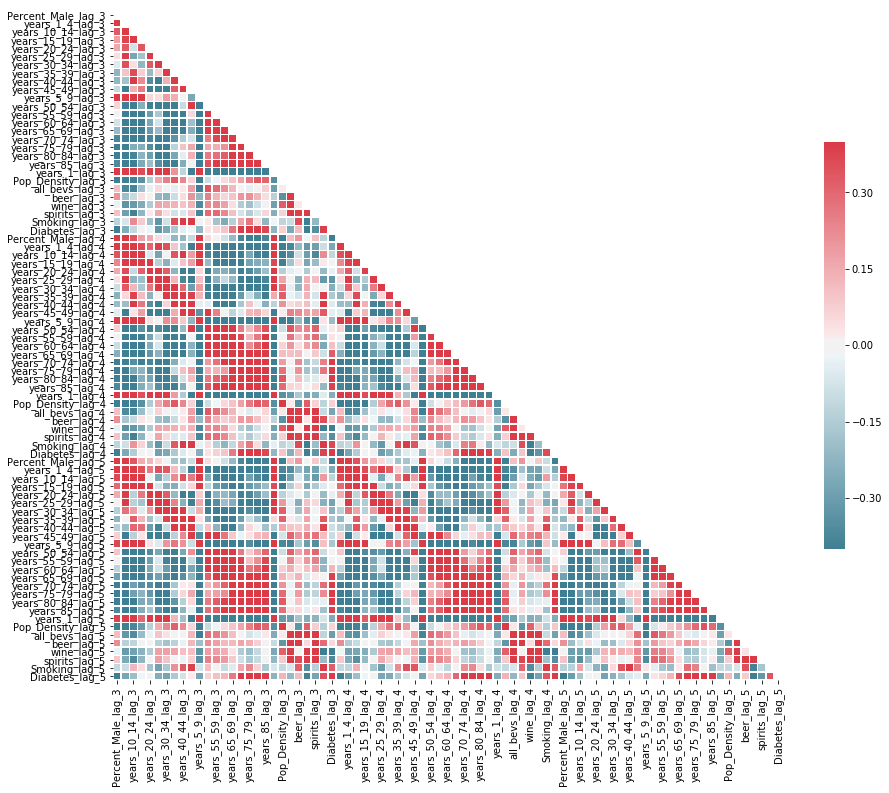

In [193]:
coll_check(features, size=(15, 15))

<a id='methodology'></a>
## Model Methodology
A number of classification models will be built in an effort to identify those which yield the greatest predictive power. Data have already undergone scaling and logarithmic transformations.

A primary component analysis will first be performed to reduce dimentionality, while still maintaining 99% of variance. A 20% of the data will be withheld from the model for testing purposes, and models will be trained on the remaining data using 5 crossfold validations. Each model will be optimized to maximize the **Accuracy Score.** The follow classification models will be utilized in conjunction with Gridsearch:

* **Decision Tree Classification**
* **Logistic Regression**
* **Support Vector Machine**
* **Random Forest Classification**
* **Adaboost**
* **XGBoost**

<a id='methodology'></a>
### Identify Top Features with PCA

In [194]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state=123)

In [195]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.99, random_state=123)
feat_pca = pca.fit_transform(features)
n_feat = feat_pca.shape[1]

print(f'Number of Features: {n_feat}\n')
print(f'Cumulative Sum Variance:\n{np.cumsum(pca.explained_variance_ratio_)}')

Number of Features: 25

Cumulative Sum Variance:
[0.32366503 0.48016187 0.60743294 0.72305189 0.78871587 0.83539886
 0.87964669 0.9004164  0.91511624 0.92814373 0.93983935 0.94929309
 0.95762409 0.96353294 0.96855536 0.97271851 0.97589422 0.97879171
 0.98094664 0.98301706 0.98494239 0.98646195 0.98782568 0.98914044
 0.99027753]


<a id='tree'></a>
### Decision Tree Pipline with PCA & Gridsearch

In [196]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

tree_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                      ('clf', DecisionTreeClassifier(random_state=123))])

tree_grid = [{'clf__criterion': ['gini', 'entropy'],
              'clf__max_depth': list(range(1, 11, 2)), 
              'clf__min_samples_split': [i/100 for i in range(5, 96, 10)], 
              'clf__min_samples_leaf': list(range(1, 11, 2))}]

tree_gridsearch = GridSearchCV(estimator = tree_pipe, 
                              param_grid = tree_grid, 
                              scoring = 'accuracy', 
                              cv=5, verbose = 1, return_train_score = True)

tree_gridsearch.fit(X_train, y_train)
print(f'Best Decision Tree Pipeline Score: {tree_gridsearch.best_score_}')
print(f'Parameters: {tree_gridsearch.best_params_}')

results = {'Pipeline': ['Decision Tree'], 
           'Top Score': [tree_gridsearch.best_score_], 
           'Parameters': [tree_gridsearch.best_params_]}

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Decision Tree Pipeline Score: 0.7037735849056603
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 0.05}


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   18.2s finished


<a id='logreg'></a>
### Logistic Regression Pipline with PCA & Gridsearch

In [197]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                        ('logreg', LogisticRegression(random_state=123))])

logreg_grid = [{'logreg__C': [.001, 0.01, 0.1, 1, 10, 100, 1000], 
                'logreg__penalty': ['l1', 'l2']}]

logreg_gridsearch = GridSearchCV(estimator = logreg_pipe, 
                                 param_grid = logreg_grid, 
                                 scoring = 'accuracy', 
                                 cv = 5, verbose = 1, return_train_score = True)

logreg_gridsearch.fit(X_train, y_train)

print(f'Best Logistic Regression Pipeline Score: {logreg_gridsearch.best_score_}')
print(f'Parameters: {logreg_gridsearch.best_params_}')

results['Pipeline'].append('Logistic Regression')
results['Top Score'].append(logreg_gridsearch.best_score_)
results['Parameters'].append(logreg_gridsearch.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Logistic Regression Pipeline Score: 0.8018867924528302
Parameters: {'logreg__C': 10, 'logreg__penalty': 'l1'}


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.9s finished


<a id='svm'></a>
### Support Vector Machine Pipeline with PCA & Gridsearch

In [198]:
from sklearn.svm import SVC

svm_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('svm', SVC(random_state=123))])

svm_grid = [{'svm__kernel': ['linear'],
             'svm__C': [.1, 1, 10], 
             'svm__degree': list(range(1, 11, 2))}, 
            
            {'svm__kernel': ['rbf'],
             'svm__C': [.1, 1, 10],
             'svm__degree': list(range(1, 11, 2)),
             'svm__gamma': [0.001, .01, 'auto']}
           ]

svm_gridsearch = GridSearchCV(estimator = svm_pipe, 
                              param_grid = svm_grid, 
                              scoring = 'accuracy', 
                              cv = 5, verbose = 1, return_train_score = True)

svm_gridsearch.fit(X_train, y_train)

print(f'Best SVM Pipeline Score: {svm_gridsearch.best_score_}')
print(f'Parameters: {svm_gridsearch.best_params_}')

results['Pipeline'].append('Support Vector Machine')
results['Top Score'].append(svm_gridsearch.best_score_)
results['Parameters'].append(svm_gridsearch.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best SVM Pipeline Score: 0.8660377358490566
Parameters: {'svm__C': 10, 'svm__degree': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    8.0s finished


<a id='rf'></a>
### Random Forest with PCA & Gridsearch

In [199]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                    ('rf', RandomForestClassifier(random_state=123))])

rf_grid = [{'rf__criterion': ['gini', 'entropy'],
            'rf__max_depth': list(range(1, 11, 2)), 
            'rf__min_samples_split': [i/100 for i in range(5, 96, 10)], 
            'rf__min_samples_leaf': list(range(1, 11, 2))}]

rf_gridsearch = GridSearchCV(estimator = rf_pipe, 
                             param_grid = rf_grid, 
                             scoring = 'accuracy', 
                             cv = 5, verbose = 1, return_train_score = True)

rf_gridsearch.fit(X_train, y_train)

print(f'Best Random Forest Pipeline Score: {rf_gridsearch.best_score_}')
print(f'Parameters: {rf_gridsearch.best_params_}')

results['Pipeline'].append('Random Forest')
results['Top Score'].append(rf_gridsearch.best_score_)
results['Parameters'].append(rf_gridsearch.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Random Forest Pipeline Score: 0.7528301886792453
Parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 7, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 0.05}


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   35.4s finished


<a id='ada'></a>
### Adaboost with PCA & Gridsearch

In [200]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('ada', AdaBoostClassifier(random_state=123))])


ada_grid = [{'ada__learning_rate': [i/100 for i in range(1, 100)]}]

ada_gridsearch = GridSearchCV(estimator = ada_pipe, 
                              param_grid = ada_grid, 
                              scoring = 'accuracy', 
                              cv = 5, verbose = 1, return_train_score = True)

ada_gridsearch.fit(X_train, y_train)

print(f'Best Adaboost Pipeline Score: {ada_gridsearch.best_score_}')
print(f'Parameters: {ada_gridsearch.best_params_}')

results['Pipeline'].append('Adaboost')
results['Top Score'].append(ada_gridsearch.best_score_)
results['Parameters'].append(ada_gridsearch.best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Adaboost Pipeline Score: 0.7113207547169811
Parameters: {'ada__learning_rate': 0.94}


[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:   47.8s finished


<a id='xgb'></a>
### XGBoost with PCA & Gridsearch

In [201]:
import xgboost as xgb

xgb_pipe = Pipeline([('pca', PCA(n_components=n_feat, random_state=123)), 
                     ('xgb', xgb.XGBClassifier())])

xgb_grid = {'xgb__learning_rate': [i/100 for i in range(5, 41, 5)],
            'xgb__max_depth': [9],
            'xgb__min_child_weight': [2],
            'xgb__subsample': [i/100 for i in range(5, 100, 10)],
            'xgb__n_estimators': [75, 90, 100]}

xgb_gridsearch = GridSearchCV(estimator = xgb_pipe, 
                              param_grid = xgb_grid, 
                              scoring = 'accuracy', 
                              cv = 5, verbose = 1, return_train_score = True)

xgb_gridsearch.fit(X_train, y_train)

print(f'Best XGBoost Pipeline Score: {xgb_gridsearch.best_score_}')
print(f'Parameters: {xgb_gridsearch.best_params_}')

results['Pipeline'].append('XGBoost')
results['Top Score'].append(xgb_gridsearch.best_score_)
results['Parameters'].append(xgb_gridsearch.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  4.5min finished


Best XGBoost Pipeline Score: 0.8226415094339623
Parameters: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 9, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 75, 'xgb__subsample': 0.45}


<a id='modresults'></a>
## Model Results

In [202]:
results_df = pd.DataFrame.from_dict(results)
results_df.to_csv('model_results.csv')
results_df

,Pipeline,Top Score,Parameters
0,Decision Tree,0.703774,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
1,Logistic Regression,0.801887,"{'logreg__C': 10, 'logreg__penalty': 'l1'}"
2,Support Vector Machine,0.866038,"{'svm__C': 10, 'svm__degree': 1, 'svm__gamma':..."
3,Random Forest,0.752830,"{'rf__criterion': 'entropy', 'rf__max_depth': ..."
4,Adaboost,0.711321,{'ada__learning_rate': 0.94}
5,XGBoost,0.822642,"{'xgb__learning_rate': 0.3, 'xgb__max_depth': ..."


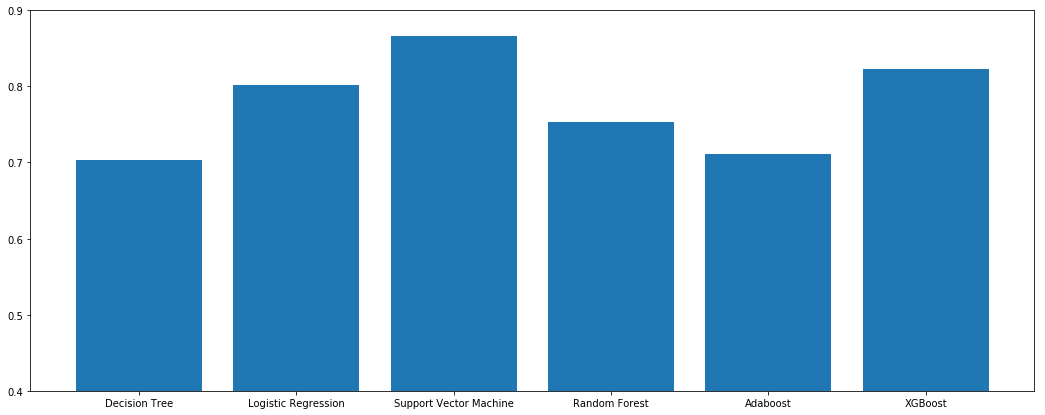

In [203]:
plt.figure(figsize=(18, 7))
plt.bar(results_df['Pipeline'], results_df['Top Score'])
plt.ylim(.4, .9)
plt.show()

In [204]:
from sklearn.metrics import accuracy_score

tree_preds = tree_gridsearch.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_preds)

logreg_preds = logreg_gridsearch.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_preds)

svm_preds = svm_gridsearch.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)

rf_preds = rf_gridsearch.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

ada_preds = ada_gridsearch.predict(X_test)
ada_accuracy = accuracy_score(y_test, rf_preds)

xgb_preds = xgb_gridsearch.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)

tot_accuracies = tree_accuracy + logreg_accuracy + svm_accuracy + rf_accuracy + ada_accuracy + xgb_accuracy

overall_preds = np.round((np.array(tree_preds) * tree_accuracy +
                 np.array(logreg_preds) * logreg_accuracy +
                 np.array(svm_preds) * svm_accuracy +
                 np.array(rf_preds) * rf_accuracy + 
                 np.array(ada_preds) * ada_accuracy + 
                 np.array(xgb_preds) * xgb_accuracy) / tot_accuracies, 0).astype(int)

overall_accuracy = accuracy_score(y_test, overall_preds)

print(f'Decision Tree Accuracy: {tree_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, tree_preds)}\n')

print(f'Logistic Regression Accuracy: {logreg_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, logreg_preds)}\n')

print(f'Support Vector Machine Accuracy: {svm_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, svm_preds)}\n')

print(f'Random Forest Accuracy: {rf_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, rf_preds)}\n')

print(f'Adaboost Accuracy: {rf_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, ada_preds)}\n')

print(f'XGBoost Accuracy: {xgb_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, xgb_preds)}\n')

print(f'Combined Accuracy: {overall_accuracy*100:.2f}%')
print(f'---------Classification Report---------\n{classification_report(y_test, overall_preds)}\n')

Decision Tree Accuracy: 69.92%
---------Classification Report---------
              precision    recall  f1-score   support

           1       0.70      0.85      0.77        55
           2       0.69      0.43      0.53        46
           3       0.70      0.81      0.75        32

   micro avg       0.70      0.70      0.70       133
   macro avg       0.70      0.70      0.69       133
weighted avg       0.70      0.70      0.68       133


Logistic Regression Accuracy: 74.44%
---------Classification Report---------
              precision    recall  f1-score   support

           1       0.80      0.87      0.83        55
           2       0.64      0.61      0.62        46
           3       0.79      0.72      0.75        32

   micro avg       0.74      0.74      0.74       133
   macro avg       0.74      0.73      0.74       133
weighted avg       0.74      0.74      0.74       133


Support Vector Machine Accuracy: 87.22%
---------Classification Report---------
        

<a id='modobvs'></a>
### Observations
The **XGBoost Model** yielded the best performance with an accuracy score of 89.47% when making predictions on unseen data. It also had the highest levels of precision and recall for high risk states at 93% and 78% respectively. 

However, the **Support Vector Machine Model** was much more efficient, performed better in cross validations, and performs with a high level of accuracy. As such, this model is preferred over **XGBoost** for making future predictions.

*Several attempts were made to combine models using weighted averages based on accuracy scores, however the results were far inferior to either of these models on their own.*

<a id='2019preds'></a>
## 2019 Predictions
Based on these results, the Support Vector Machine Model will be used to make predictions for 2019. All data associated will 2016 will be treated as 3 - 5 year lag data, and 2016 results will be compared with 2019 predictions.

In [212]:
# Create dataframe from 2016 data
pred_2019_df = lag_df[lag_df.columns[:-1]]
pred_2019_df = pred_2019_df[pred_2019_df.index.str[-4:]=='2016']
pred_2019_df['State_2019'] = pred_2019_df.index.str[:-5]
pred_2019_df = pred_2019_df.set_index('State_2019')
print(pred_2019_df.shape)
pred_2019_df.head()

(51, 162)


,Percent_Male,years_1_4,years_10_14,years_15_19,years_20_24,years_25_29,years_30_34,years_35_39,years_40_44,years_45_49,...,years_80_84_lag_5,years_85_lag_5,years_1_lag_5,Pop_Density_lag_5,all_bevs_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,Smoking_lag_5,Diabetes_lag_5
State_2019,,,,,,,,,,,,,,,,,,,,,
Alabama,-1.051999,-0.629633,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,-1.290327,-1.141212,...,0.135407,-0.143233,-0.431463,-0.006250,-0.845177,-0.253356,-0.599801,-0.809918,0.543322,0.379440
Alaska,3.739304,1.176875,-0.200565,-1.317296,0.918602,2.157388,1.697301,-0.107274,-1.637848,-1.711503,...,-3.807296,-3.335340,1.800565,-2.839803,0.944694,-0.301499,0.946063,1.394341,0.252051,-2.176276
Arizona,0.550417,-0.179050,-0.237862,-0.593898,-0.085895,0.471467,-0.107045,-0.633062,-1.406257,-1.676047,...,0.189955,0.004161,0.183605,-0.339951,0.070854,-0.301499,0.555666,0.170417,-1.442760,0.424952
Arkansas,-0.173192,-0.094316,-0.308263,-0.768788,-0.370142,0.149028,-0.405066,-0.664172,-1.435120,-1.625246,...,0.269494,0.226763,-0.002075,-0.345314,-1.530376,-1.190978,-1.148205,-0.977935,0.726620,1.026870
California,0.515121,-0.174144,-0.577187,-0.910627,0.121316,1.472418,1.027240,0.048470,-0.800256,-0.784109,...,-0.616207,-0.040236,0.325036,0.609805,-0.222959,-1.363857,1.082284,-0.168802,-1.892214,-0.776703


In [215]:
pred_2019_df.columns[27:]

Index(['Percent_Male_lag_1', 'years_1_4_lag_1', 'years_10_14_lag_1',
       'years_15_19_lag_1', 'years_20_24_lag_1', 'years_25_29_lag_1',
       'years_30_34_lag_1', 'years_35_39_lag_1', 'years_40_44_lag_1',
       'years_45_49_lag_1',
       ...
       'years_80_84_lag_5', 'years_85_lag_5', 'years_1_lag_5',
       'Pop_Density_lag_5', 'all_bevs_lag_5', 'beer_lag_5', 'wine_lag_5',
       'spirits_lag_5', 'Smoking_lag_5', 'Diabetes_lag_5'],
      dtype='object', length=135)

In [216]:
# Rename columns as lag identifiers (i.e. 2016 data represents a 3 year lag relative to 2019 predictions)
col_renames = {}

for col in pred_2019_df.columns[:27]:
    col_renames[col] = f'{col}_lag_3'

for col in pred_2019_df.columns[27:]:
    col_renames[col] = f'{col[:-1]}{int(col[-1])+3}'

pred_2019_df = pred_2019_df.rename(columns=col_renames)
pred_2019_df = pred_2019_df[pred_2019_df.columns[:-81]]
print(pred_2019_df.shape)
pred_2019_df.head()

(51, 81)


,Percent_Male_lag_3,years_1_4_lag_3,years_10_14_lag_3,years_15_19_lag_3,years_20_24_lag_3,years_25_29_lag_3,years_30_34_lag_3,years_35_39_lag_3,years_40_44_lag_3,years_45_49_lag_3,...,years_80_84_lag_5,years_85_lag_5,years_1_lag_5,Pop_Density_lag_5,all_bevs_lag_5,beer_lag_5,wine_lag_5,spirits_lag_5,Smoking_lag_5,Diabetes_lag_5
State_2019,,,,,,,,,,,,,,,,,,,,,
Alabama,-1.051999,-0.629633,-0.746468,-0.853802,-0.269649,0.255020,-0.619302,-0.791105,-1.290327,-1.141212,...,0.139909,0.093588,-0.612363,-0.000609,-0.796258,-0.399053,-0.521983,-0.650235,-0.061352,0.352235
Alaska,3.739304,1.176875,-0.200565,-1.317296,0.918602,2.157388,1.697301,-0.107274,-1.637848,-1.711503,...,-3.563390,-2.861940,1.419387,-2.826746,0.824079,-0.498350,0.874119,1.366705,0.034256,-2.025151
Arizona,0.550417,-0.179050,-0.237862,-0.593898,-0.085895,0.471467,-0.107045,-0.633062,-1.406257,-1.676047,...,0.275536,0.310403,-0.102190,-0.315916,0.029951,-0.158302,0.373978,0.129918,-2.467164,0.730626
Arkansas,-0.173192,-0.094316,-0.308263,-0.768788,-0.370142,0.149028,-0.405066,-0.664172,-1.435120,-1.625246,...,0.303260,0.376505,-0.125605,-0.339492,-1.336209,-1.305632,-0.854350,-0.650235,0.534634,0.586359
California,0.515121,-0.174144,-0.577187,-0.910627,0.121316,1.472418,1.027240,0.048470,-0.800256,-0.784109,...,-0.657803,0.186022,-0.060243,0.627501,-0.073836,-1.078642,1.146910,-0.124393,-2.455796,-0.591149


<a id='2019results'></a>
### Results

In [217]:
svm_2019_preds = svm_gridsearch.predict(pred_2019_df)
pred_2019_df['SVM Predict'] = svm_2019_preds
pred_2019_df['SVM Predict']

State_2019
Alabama                 3
Alaska                  1
Arizona                 1
Arkansas                3
California              1
Colorado                1
Connecticut             2
Delaware                2
District of Columbia    2
Florida                 2
Georgia                 1
Hawaii                  1
Idaho                   1
Illinois                1
Indiana                 2
Iowa                    2
Kansas                  1
Kentucky                2
Louisiana               2
Maine                   2
Maryland                1
Massachusetts           1
Michigan                3
Minnesota               1
Mississippi             3
Missouri                2
Montana                 2
Nebraska                1
Nevada                  2
New Hampshire           2
New Jersey              2
New Mexico              1
New York                2
North Carolina          2
North Dakota            1
Ohio                    3
Oklahoma                3
Oregon                  1
P

In [218]:
get2016df = pd.read_csv('final_dataset.csv')
get2016df = get2016df[get2016df['State_Year'].str[-4:] == '2016'][['State_Year', 'Risk_Level']]

pred_2019_df['2016 Risk Level'] = np.array(get2016df['Risk_Level'])
pred_2019_df = pred_2019_df[['SVM Predict', '2016 Risk Level']]
pred_2019_df['Difference'] = pred_2019_df['SVM Predict'] - pred_2019_df['2016 Risk Level']
pred_2019_df[(pred_2019_df['Difference'] != 0)|(pred_2019_df['SVM Predict'] == 3)]

,SVM Predict,2016 Risk Level,Difference
State_2019,,,
Alabama,3,3,0
Arkansas,3,3,0
Illinois,1,2,-1
Kansas,1,2,-1
Kentucky,2,3,-1
Louisiana,2,3,-1
Michigan,3,3,0
Mississippi,3,3,0
Missouri,2,3,-1


In [219]:
pred_2019_df.to_csv('2019_predictions.csv')

In [87]:
T1 = time.time()
tot_T = (T1 - T0) / 60
mins = int(tot_T)
secs = (tot_T - mins) * 60
print(f'Time to Complete: {mins}m {int(secs)}s')

Time to Complete: 44m 35s


<a id='concs'></a>
## Conclusions
<a id='concobvs'></a>
### Observations
Overall improvements in heart disease deaths are expected in 2019, with risk levels dropping for the following states:
* **Illinois**: Medium Risk to Low Risk
* **Kansas**: Medium Risk to Low Risk
* **Kentucky**: High Risk to Medium Risk
* **Louisiana**: High Risk to Medium Risk
* **Missouri**: High Risk to Medium Risk

Increased risk for:
* **North Carolina**: Low Risk to Medium Risk<br><br>

States that remain a high risk are the following:
* **Alabama**
* **Arkansas**
* **Michigan**
* **Mississippi**
* **Ohio**
* **Oklahoma**
* **Pennsylvania**
* **West Virginia**
<a id='reco'></a>

### Recommendation
Implement a gradual reduction in resources from states regarded as low risk to those that remain high risk. Because precision, recall, and accuracy scores were lowest for medium risk classifications, it is best to not make any reductions in those states.
<a id='next'></a>
### Next Steps

1. While certain behavioral factors can be useful in reducing risk for heart disease, demographic factors cannot be mitigated. For high risk states, it would be good to investigate the primary drivers of risk on a state-by-state basis because this will help inform a proper distribution of resources. For example, if the risk level is driven primarily by smoking habits, it might be useful to launch an ad campaign that attempts to get people to quit. However, if the risk level is driven primarily by an aging population, a specific focus on providing additional hospital support would be more appropriate.<br><br>
2. At the moment, the only behavioral factor that seems to have a significant impact on risk level is smoking. Gathering additional data on habits related to diet and exercise should drive higher accuracy scores in the model, and will allow for more options related to resource distribution.<br><br>
3. Perform similar analysis related to **Cancer** and other causes of death in effort to identify upcoming trends.